In [1]:
# Imports :

import numpy as np
import pandas as pd
import string 
import pickle

# Plot : 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

from sklearn.model_selection import train_test_split, GridSearchCV
from skopt import BayesSearchCV

# Utils for encoding : 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

# Utils for regression : 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, make_scorer

# Utils for classification :
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier, plot_importance
from sklearn.ensemble import HistGradientBoostingClassifier

# Utils for Metrics calculation : 
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve
from metrics_utils import rewrite_keys, rapport_metrics_decision_tree
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict

# Custom utils  
from Opti_utils.ML_utils import find_best_threshold, from_model_to_bst_trhld, custom_metrics, scores, compare_results,find_error
from Opti_utils.ML_utils import FP, TP, FN, TN, check_corr_col, filtre_list, fit_method, check_baseline, check_FP_FN, check_best_results
from Opti_utils.ML_utils import ML_opti_recueil, univariate_ml, sensi, speci, mix_sensi_speci, custom_metric
from Opti_utils.ML_utils import Binarisation, model_to_plot, clean_lists

# Ouverture des datas : 

In [2]:
recueil_imc  = pd.read_excel('./../../Data/Raw/Recueil (1).xlsx').drop('Unnamed: 90', axis=1)
recueil_imc.shape

(181, 90)

In [3]:
# On enlève les colonnes liés a la chirurgie : 
liste_colonnes_chir = ['date.chir', 'chir.macro.lusd', 'chir.macro.lusg', 'chir.macro.torus',  'chir.macro.oma', 'chir.macro.uro', 'chir.macro.dig',  'chir.macro.superf', 'resec.lusd', 'resec.lusg', 'resec.torus', 'resec.autre']
for col_to_drop in liste_colonnes_chir:
    recueil_imc = recueil_imc.drop(col_to_drop, axis=1)
# Remplace les manquantes par un np.nan
recueil_imc.replace(['Na', 'NA', 'nan', 'Nan', 'NAN'], np.nan, inplace=True)
# n_ano en Index
recueil_imc = recueil_imc.set_index('Numéro anonymat')
recueil_imc.shape

C:\Users\nwolpert\AppData\Local\Temp\ipykernel_7312\2947652957.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  recueil_imc.replace(['Na', 'NA', 'nan', 'Nan', 'NAN'], np.nan, inplace=True)


(181, 77)

In [23]:
recueil_imc

,chir,age,imc,g,p,atcd.endo,atcd.chir.oma,atcd.fibrome,atcd.chir.endo,atcd.infertilite,...,irm.epanchement,irm.opac.vagin,irm.opac.rectum,irm.xr,irm.externe,avis.dig/uro,anapath.lusd,anapath.lusg,anapath.torus,anapath.autre
Numéro anonymat,,,,,,,,,,,,,,,,,,,,,
NJ-001,PSH,39,20.7,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,1,0,0
JJ-002,SW,36,21.6,5,3,0,0,0,0,0,...,0,1,1,1,0,0,0,1,0,1
LA-003,SW,41,32.5,1,0,0,0,0,0,1,...,0,1,1,0,1,0,0,0,0,0
DS-004,PSH,27,15.9,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
BM-005,GD,37,22.9,1,0,1,0,0,1,0,...,0,0,0,0,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WL-197,GD,37,23.4,1,1,1,1,0,0,0,...,0,1,1,1,0,0,1,1,0,0
TC-198,SW,27,35.8,2,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
BD-200,GD,44,26.0,1,1,1,1,0,1,1,...,1,0,1,0,1,0,0,0,1,0


# Préparation pour le ML : 

## Split des features et des targets : 

In [4]:
# recueil_imc.dropna(axis=0, inplace=True)
target = recueil_imc.iloc[:,-4:].copy()
features = recueil_imc.iloc[:,:-4].copy()

endometriose = target.loc[:,['anapath.lusd','anapath.lusg','anapath.torus']].sum(axis=1).apply(lambda x: Binarisation(x))

recueil_imc_endo = recueil_imc.copy()
recueil_imc_endo['endometriose'] = endometriose
recueil_imc_endo.shape

(181, 78)

## Préparation des données : 

In [5]:
features_chir_ONE = pd.get_dummies(features.loc[:,'chir'], prefix='chir')
features_dsptype_ONE = pd.get_dummies(features.loc[:,'sf.dsp.type'].replace(0, 'aucun'), prefix='dsp.type')
features_enc = pd.concat([features.drop('chir', axis=1).drop('sf.dsp.type', axis=1), features_chir_ONE, features_dsptype_ONE], axis=1)

In [6]:
# split 
X_train, X_test, y_train, y_test = train_test_split(features_enc, endometriose, random_state=42, stratify=endometriose)

In [7]:
scorer = make_scorer(custom_metric, greater_is_better=True)
mix_recall = make_scorer(mix_sensi_speci, greater_is_better=True)
sensibilite = make_scorer(sensi, greater_is_better=True)
specificite = make_scorer(speci, greater_is_better=True)
scorers = { 'speci': specificite, 'sensi' : sensibilite}

## Résultats : 

In [8]:
with open('./../../Data/Generate/data.pkl', 'rb') as f1:
    dictionnary_list = pickle.load(f1)
    
liste_col_speci= dictionnary_list['specifite']
liste_col_sensi = dictionnary_list['sensibilite']
liste_col_mixte = dictionnary_list['moyenne']

In [9]:
liste_col_speci

['age',
 'imc',
 'p',
 'atcd.chir.oma',
 'atcd.fibrome',
 'atcd.chir.endo',
 'atcd.pma',
 'atcd.fiv',
 'desir.G',
 'atcd.sma.douleur',
 'atcd.hospit.douleur',
 'atcd.absenteisme',
 'ttt.op',
 'ttt.p',
 'ttt.ains',
 'ttt.p1',
 'ttt.p2',
 'ttt.p3',
 'sf.dsm.type',
 'sf.dsm.eva',
 'sf.dpc',
 'sf.dsp.eva',
 'sf.dig.diarrhee',
 'sf.dig.constip',
 'sf.dig.rectorragie',
 'sf.uro',
 'sf.scap',
 'sf.ombilic',
 'ef.hormone.dsp',
 'ef.hormone.dsm',
 'ef.hormone.dpc',
 'effet.hormone.dig',
 'tv.douloureux',
 'tv.douleur.lusd',
 'tv.douleur.lusg',
 'tv.douleur.torus',
 'tv.nodule.lusd',
 'tv.nodule.lusg',
 'tv.nodule.torus',
 'spec.nodule',
 'echo.adm',
 'echo.noduleRV',
 'echo.lusd',
 'echo.lusg',
 'echo.torus',
 'echo.rectum',
 'echo.sigmoide',
 'irm.endo',
 'irm.adm',
 'irm.lusd',
 'irm.lusg',
 'irm.torus',
 'irm.oma',
 'irm.dig',
 'irm.vagin',
 'irm.kissing',
 'irm.adherences',
 'irm.retroversion',
 'irm.epanchement',
 'irm.opac.vagin',
 'irm.opac.rectum',
 'irm.externe',
 'avis.dig/uro',
 'chi

In [10]:
liste_col_sensi = clean_lists(liste_col_sensi)
liste_col_speci = clean_lists(liste_col_speci)
liste_col_mixte = clean_lists(liste_col_mixte)

# Essais de ML avec les colonnes :

In [13]:
seed = 42 

In [14]:
## Init Metrics :
scorer = make_scorer(custom_metric, greater_is_better=True)
mix_recall = make_scorer(mix_sensi_speci, greater_is_better=True)
sensibilite = make_scorer(sensi, greater_is_better=True)
specificite = make_scorer(speci, greater_is_better=True)

In [15]:
# Params :
param1 = {'min_child_weight': [1, 5, 10],
 'gamma': [0, 0.5, 1, 1.5, 2, 5],
 'subsample': [0.6, 0.8, 1.0],
 'colsample_bytree': [0.6, 0.8, 1.0],
 'max_depth': [3, 4, 5, 6, 7, 8],
 'n_estimators': [50, 100, 150, 200, 300, 500]}

## Base line : 

In [16]:
# On enlève les colonnes correlées : 
X_train_ = X_train.copy()
X_test_ = X_test.copy()

liste_to_drop = ['p','atcd.chir.endo','atcd.infertilite','sf.dsm','sf.dsp','ef.hormone.dsm','echo.oma','irm.xr']
for col in liste_to_drop:
    X_test_.drop(col, axis=1, inplace=True)
    X_train_.drop(col, axis=1, inplace=True)

In [17]:
tree_1 = XGBClassifier(random_state=seed)
test_cv = cross_validate(tree_1, X_train_, y_train, cv=5, scoring=scorers, return_estimator =True)

print('sensi : ',round(test_cv['test_sensi'].mean(), 2))
print('speci : ',round(test_cv['test_speci'].mean(),2))

sensi :  0.61
speci :  0.48


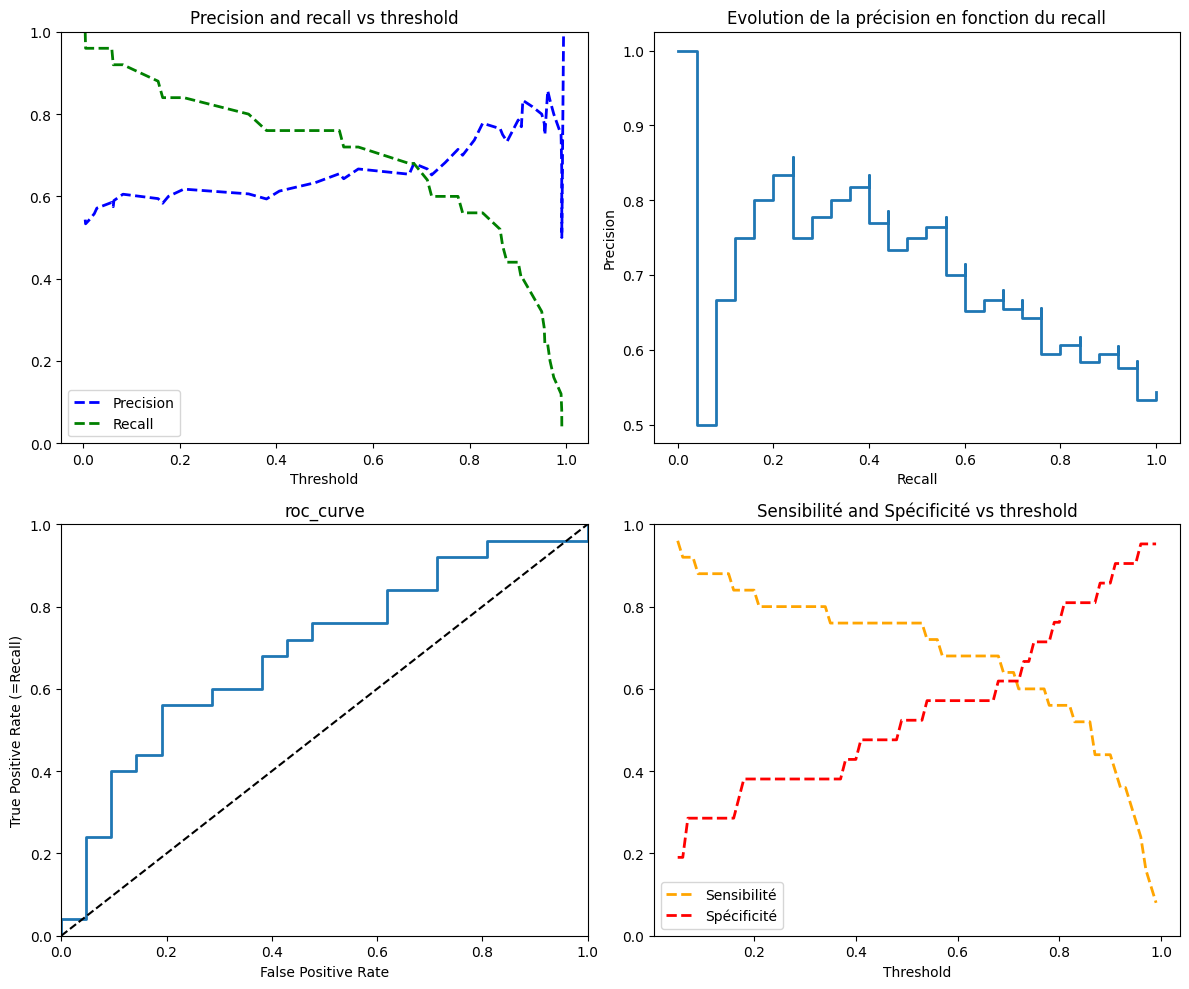

threshold = 0,5
Sensibilité :  0.76
Spécificité :  0.5238095238095238
_________________________________________________________
Best threshold : 0.81
Sensibilité : 0.56
Spécificité : 0.8095238095238095


In [19]:
tree_BL = XGBClassifier(random_state=seed)
tree_BL.fit(X_train_, y_train)
pred_BL = tree_BL.predict(X_test_)
model_to_plot(tree_BL, X_test_, y_test)
resultat_BL = pd.DataFrame(pd.Series(scores(y_test, pred_BL)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_BL.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_BL.loc['specificité','XGB_BL_sensi'])
dict_ = from_model_to_bst_trhld(tree_BL, X_test_, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_['best_threshold'])
print('Sensibilité :', dict_['scores']['sensibilite'])
print('Spécificité :', dict_['scores']['specificité'])

                feature  importance
0                  age        55.0
1                  imc        49.0
15          sf.dsp.eva        36.0
13          sf.dsm.eva        29.0
2                    g        27.0
3            atcd.endo        23.0
42            irm.lusg        22.0
25       tv.douloureux        18.0
48         irm.externe        16.0
16     sf.dig.diarrhee        16.0
36           echo.lusg        15.0
35           echo.lusd        15.0
23      ef.hormone.dpc        15.0
21       effet.hormone        14.0
9     atcd.absenteisme        13.0
26     tv.douleur.lusd        12.0
8     atcd.sma.douleur        11.0
33            echo.adm        11.0
46    irm.retroversion        10.0
49            chir_CAP        10.0
7              desir.G        10.0
37          echo.torus         9.0
47     irm.opac.rectum         9.0
18  sf.dig.rectorragie         9.0
19              sf.uro         7.0
17      sf.dig.constip         7.0
11              ttt.p2         6.0
10               tt

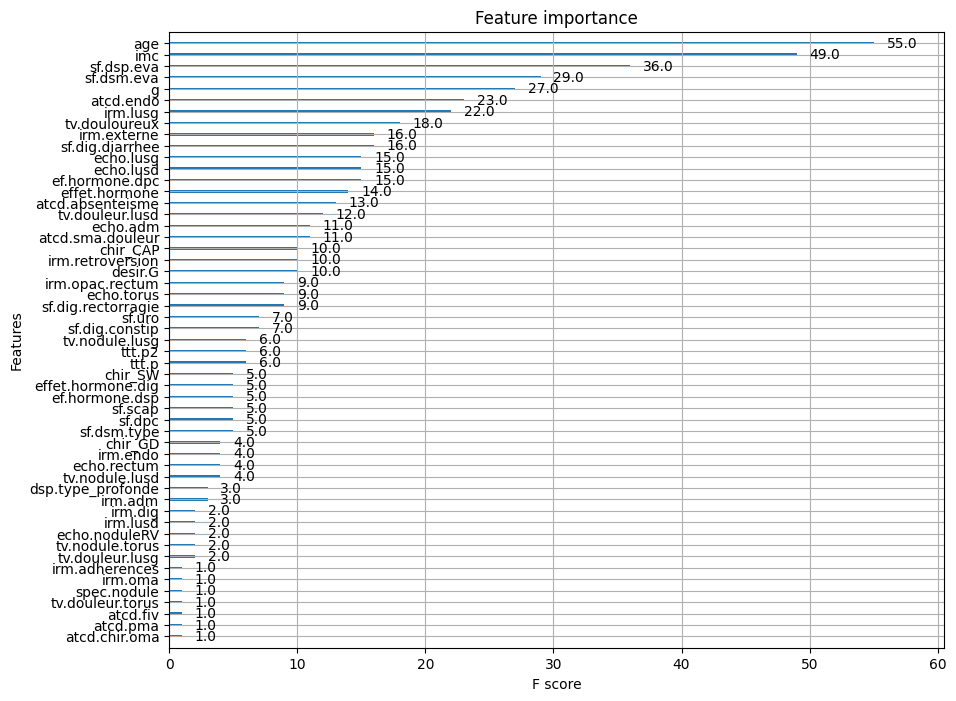

In [22]:
xgb_fea_imp=pd.DataFrame(list(tree_BL.get_booster().get_fscore().items()),
columns=['feature','importance']).sort_values('importance', ascending=False)
print('',xgb_fea_imp)
xgb_fea_imp.to_csv('xgb_fea_imp.csv')

from xgboost import plot_importance
ax = plot_importance(tree_BL, )
ax.figure.set_size_inches(10,8)

### <u>Optimisation Baseline</u> : 

#### Sensi :

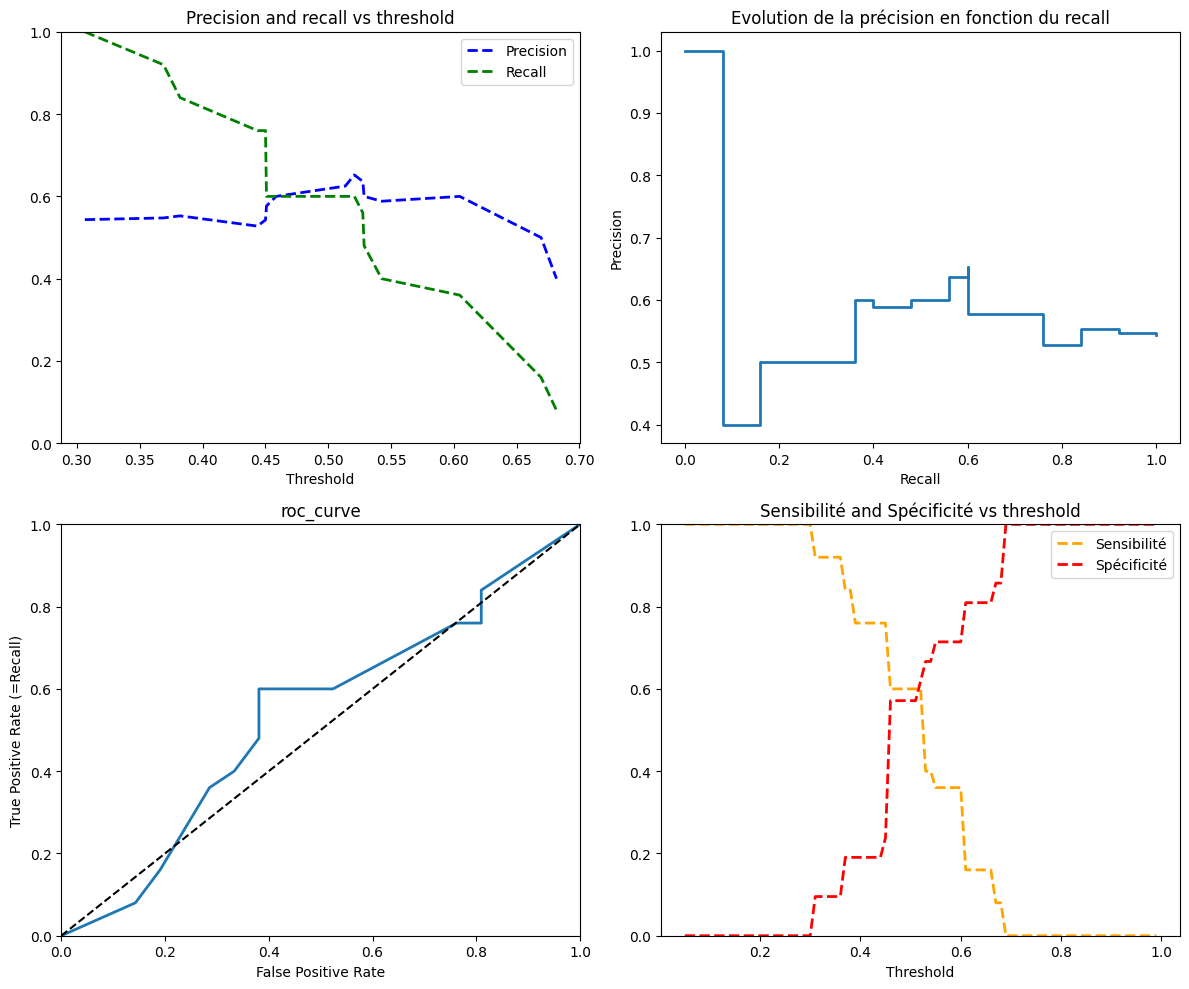

threshold = 0,5
Sensibilité :  0.6
Spécificité :  0.5714285714285714
_________________________________________________________
Best threshold : 0.61
Sensibilité : 0.16
Spécificité : 0.8095238095238095


In [38]:
# Model !
tree_1_opti = XGBClassifier(random_state=seed)
# Hyperparameter tuning
gs = BayesSearchCV(tree_1_opti, param1, scoring=sensibilite, random_state=seed)
gs.fit(X_train_, y_train)
# Refit a model with this fine tuned params
tree_opti_hp1 = XGBClassifier(**dict(gs.best_params_),random_state=seed)
tree_opti_hp1.fit(X_train_, y_train)
# Results :
pred_opti1 = tree_opti_hp1.predict(X_test_)
model_to_plot(tree_opti_hp1, X_test_, y_test)
resultat__sensi_1 = pd.DataFrame(pd.Series(scores(y_test, pred_opti1)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat__sensi_1.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat__sensi_1.loc['specificité','XGB_BL_sensi'])
dict_sensi_1 = from_model_to_bst_trhld(tree_opti_hp1, X_test_, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_1['best_threshold'])
print('Sensibilité :', dict_sensi_1['scores']['sensibilite'])
print('Spécificité :', dict_sensi_1['scores']['specificité'])

#### Spéci :

C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


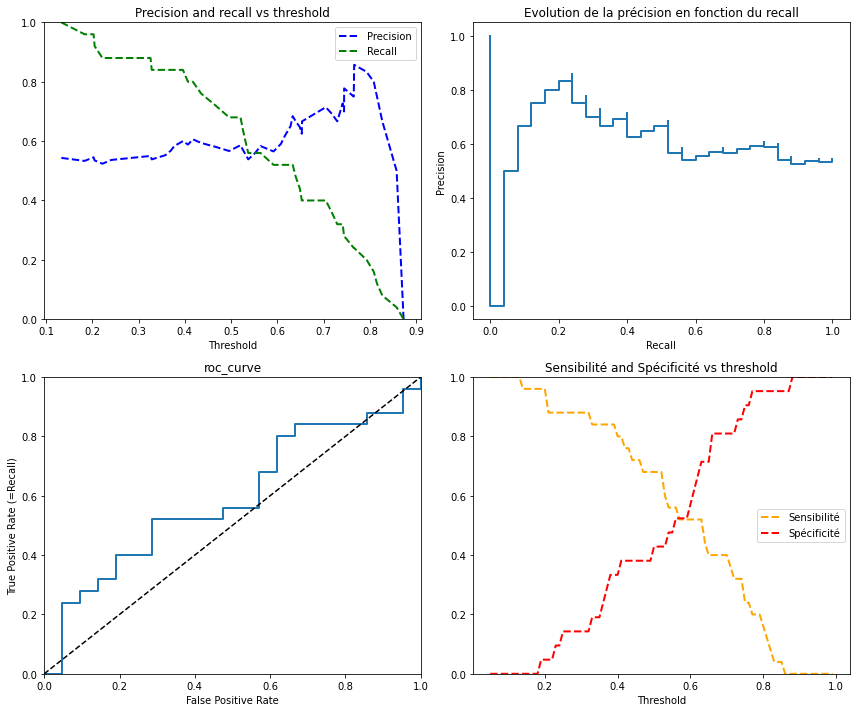

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.42857142857142855
_________________________________________________________
Best threshold : 0.66
Sensibilité : 0.4
Spécificité : 0.8095238095238095


In [17]:
tree_2_opti = XGBClassifier(random_state=seed)
gs2 = BayesSearchCV(tree_2_opti, param1, scoring=specificite, random_state=seed)
gs2.fit(X_train_, y_train)
tree_opti_hp2 = XGBClassifier(**dict(gs2.best_params_),random_state=seed)
tree_opti_hp2.fit(X_train_, y_train)
# Results :
pred_opti2 = tree_opti_hp2.predict(X_test_)
model_to_plot(tree_opti_hp2, X_test_, y_test)
resultat__sensi_2 = pd.DataFrame(pd.Series(scores(y_test, pred_opti2)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat__sensi_2.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat__sensi_2.loc['specificité','XGB_BL_sensi'])
dict_sensi_2 = from_model_to_bst_trhld(tree_opti_hp2, X_test_, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_2['best_threshold'])
print('Sensibilité :', dict_sensi_2['scores']['sensibilite'])
print('Spécificité :', dict_sensi_2['scores']['specificité'])

#### F1 :

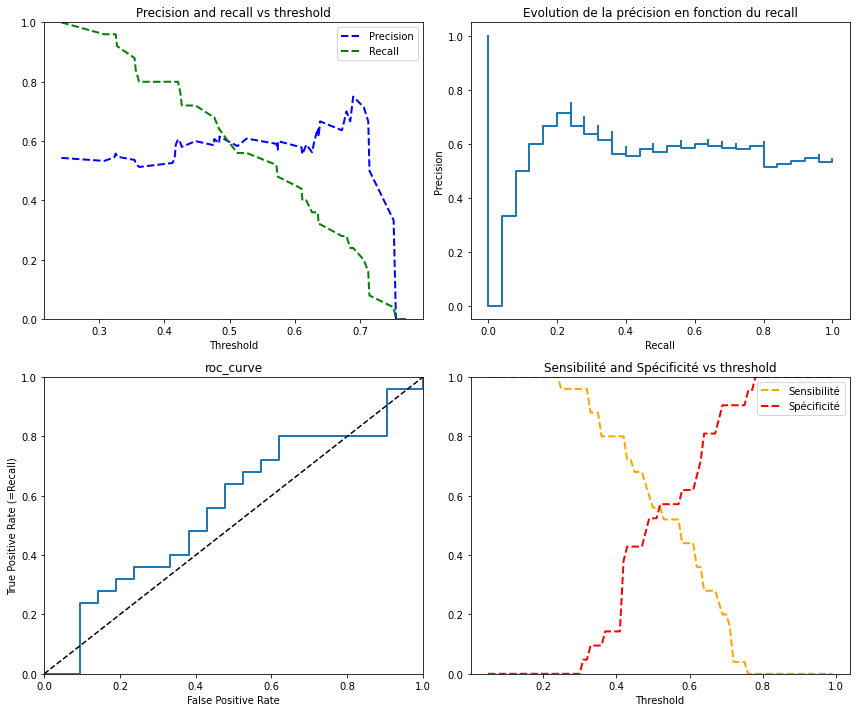

threshold = 0,5
Sensibilité :  0.56
Spécificité :  0.5238095238095238
_________________________________________________________
Best threshold : 0.64
Sensibilité : 0.28
Spécificité : 0.8095238095238095


In [18]:
tree_3_opti = XGBClassifier(random_state=seed)
gs3 = BayesSearchCV(tree_3_opti, param1, scoring='f1', random_state=seed)
gs3.fit(X_train_, y_train)
tree_opti_hp3 = XGBClassifier(**dict(gs3.best_params_),random_state=seed)
tree_opti_hp3.fit(X_train_, y_train)
# Results :
pred_opti3 = tree_opti_hp3.predict(X_test_)
model_to_plot(tree_opti_hp3, X_test_, y_test)
resultat__sensi3 = pd.DataFrame(pd.Series(scores(y_test, pred_opti3)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat__sensi3.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat__sensi3.loc['specificité','XGB_BL_sensi'])
dict_sensi_3 = from_model_to_bst_trhld(tree_opti_hp3, X_test_, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_3['best_threshold'])
print('Sensibilité :', dict_sensi_3['scores']['sensibilite'])
print('Spécificité :', dict_sensi_3['scores']['specificité'])

#### Custom :

C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been

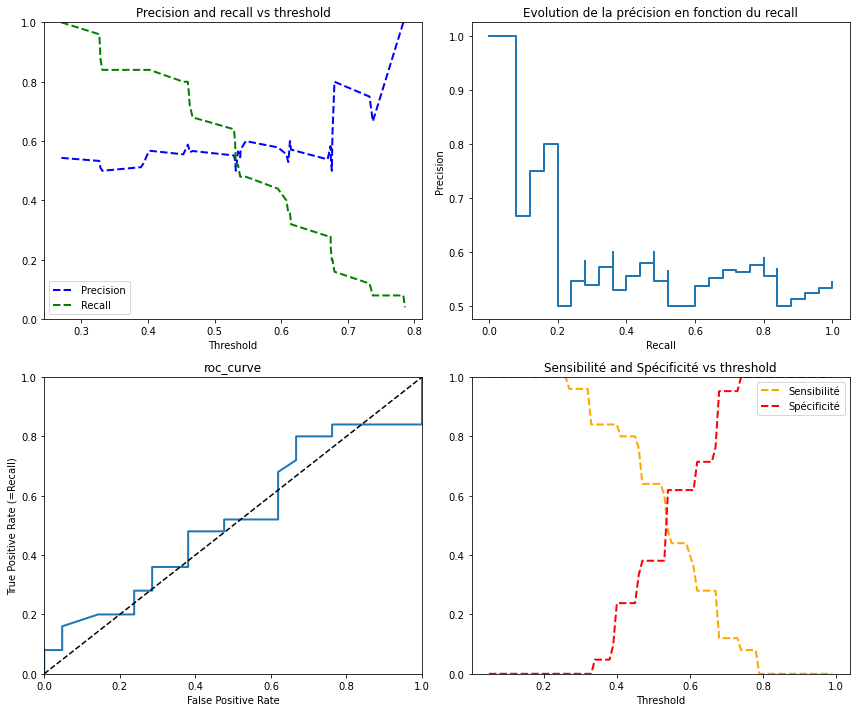

threshold = 0,5
Sensibilité :  0.64
Spécificité :  0.38095238095238093
_________________________________________________________
Best threshold : 0.68
Sensibilité : 0.12
Spécificité : 0.9523809523809523


In [19]:
tree_4_opti = XGBClassifier(random_state=seed)
gs4 = BayesSearchCV(tree_4_opti, param1, scoring=scorer, random_state=seed)
gs4.fit(X_train_, y_train)
tree_opti_hp4 = XGBClassifier(**dict(gs4.best_params_),random_state=seed)
tree_opti_hp4.fit(X_train_, y_train)
# Results :
pred_opti4 = tree_opti_hp4.predict(X_test_)
model_to_plot(tree_opti_hp4, X_test_, y_test)
resultat__sensi4 = pd.DataFrame(pd.Series(scores(y_test, pred_opti4)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat__sensi4.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat__sensi4.loc['specificité','XGB_BL_sensi'])
dict_sensi_4 = from_model_to_bst_trhld(tree_opti_hp4, X_test_, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_4['best_threshold'])
print('Sensibilité :', dict_sensi_4['scores']['sensibilite'])
print('Spécificité :', dict_sensi_4['scores']['specificité'])

#### Mix :

C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been

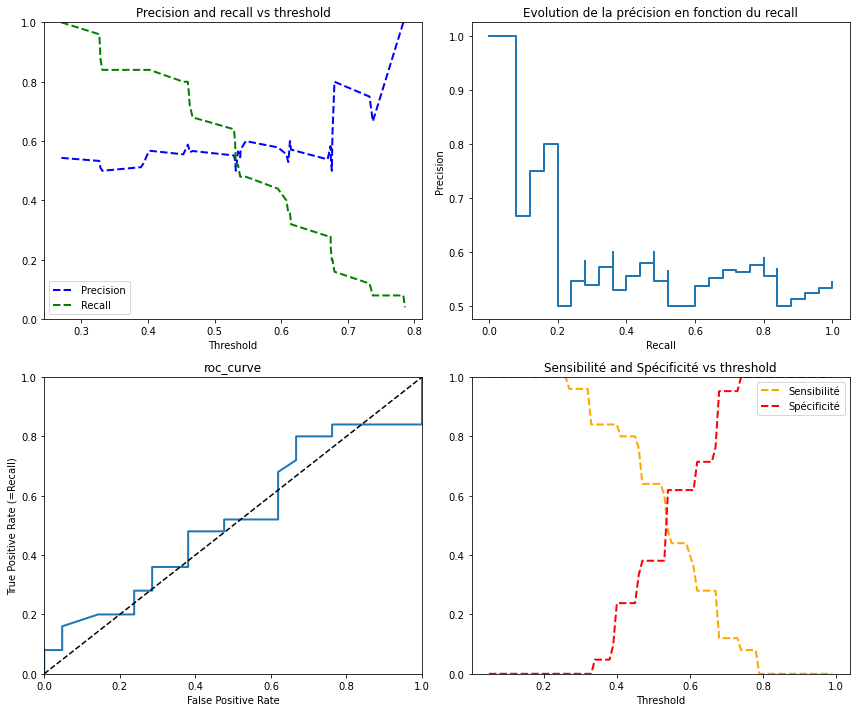

threshold = 0,5
Sensibilité :  0.64
Spécificité :  0.38095238095238093
_________________________________________________________
Best threshold : 0.68
Sensibilité : 0.12
Spécificité : 0.9523809523809523


In [20]:
tree_5_opti = XGBClassifier(random_state=seed)
gs5 = BayesSearchCV(tree_5_opti, param1, scoring=mix_recall, random_state=seed)
gs5.fit(X_train_, y_train)
tree_opti_hp5 = XGBClassifier(**dict(gs5.best_params_),random_state=seed)
tree_opti_hp5.fit(X_train_, y_train)
# Results :
pred_opti5 = tree_opti_hp5.predict(X_test_)
model_to_plot(tree_opti_hp5, X_test_, y_test)
resultat__sensi5 = pd.DataFrame(pd.Series(scores(y_test, pred_opti5)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat__sensi5.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat__sensi5.loc['specificité','XGB_BL_sensi'])
dict_sensi_5 = from_model_to_bst_trhld(tree_opti_hp5, X_test_, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_5['best_threshold'])
print('Sensibilité :', dict_sensi_5['scores']['sensibilite'])
print('Spécificité :', dict_sensi_5['scores']['specificité'])

#### average precision

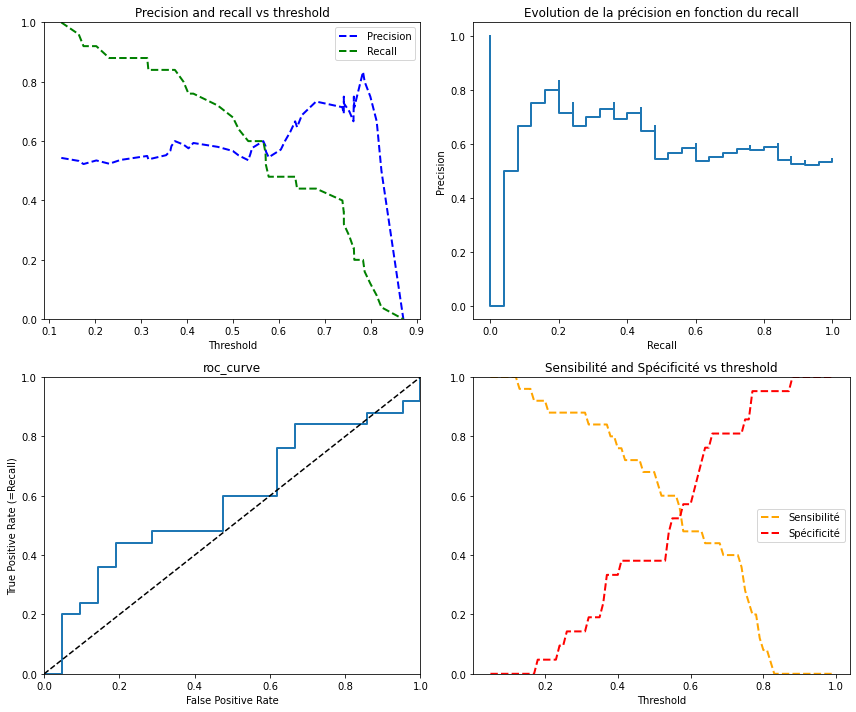

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.38095238095238093
_________________________________________________________
Best threshold : 0.66
Sensibilité : 0.44
Spécificité : 0.8095238095238095


In [21]:
tree_6_opti = XGBClassifier(random_state=seed)
gs6 = BayesSearchCV(tree_6_opti, param1, scoring='average_precision', random_state=seed)
gs6.fit(X_train_, y_train)
tree_opti_hp6 = XGBClassifier(**dict(gs6.best_params_),random_state=seed)
tree_opti_hp6.fit(X_train_, y_train)
# Results :
pred_opti6 = tree_opti_hp6.predict(X_test_)
model_to_plot(tree_opti_hp6, X_test_, y_test)
resultat__sensi6 = pd.DataFrame(pd.Series(scores(y_test, pred_opti6)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat__sensi6.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat__sensi6.loc['specificité','XGB_BL_sensi'])
dict_sensi_6 = from_model_to_bst_trhld(tree_opti_hp6, X_test_, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_6['best_threshold'])
print('Sensibilité :', dict_sensi_6['scores']['sensibilite'])
print('Spécificité :', dict_sensi_6['scores']['specificité'])

# Essais de Feature selection avec les colonnes du ML univarié

## ML sensibilité : 

### XGB : 

In [39]:
tree_sensi = XGBClassifier(random_state=seed)
xgb_sensi = cross_validate(tree_1, X_train.loc[:,liste_col_sensi], y_train, cv=5, scoring=scorers, return_estimator =True)

print('sensi : ',round(xgb_sensi['test_sensi'].mean(), 2))
print('speci : ',round(xgb_sensi['test_speci'].mean(),2))

sensi :  0.61
speci :  0.46


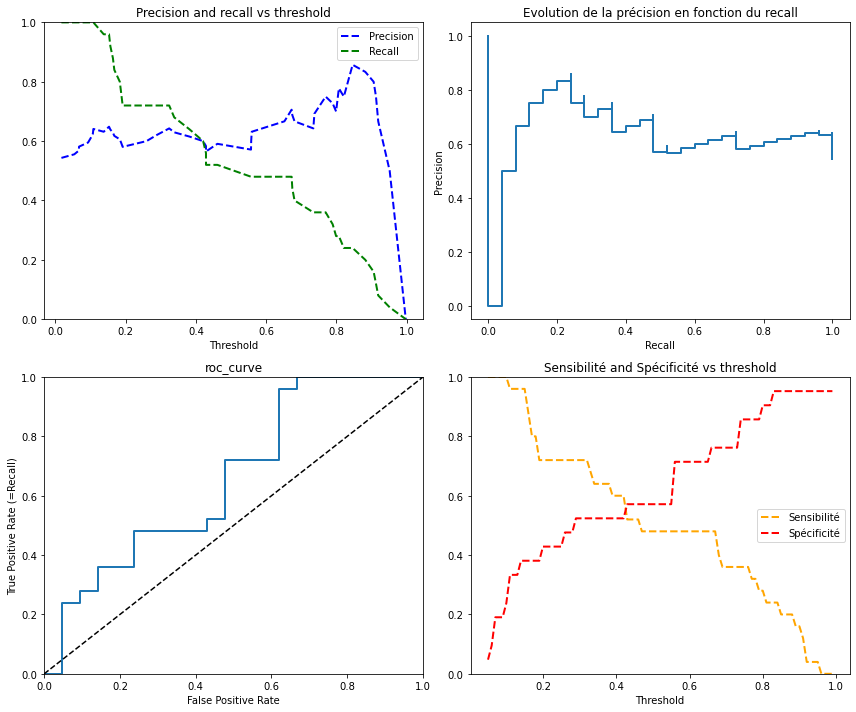

threshold = 0,5
Sensibilité :  0.48
Spécificité :  0.5714285714285714
_________________________________________________________
Best threshold : 0.74
Sensibilité : 0.36
Spécificité : 0.8571428571428571


In [23]:
tree_BL_sensi = XGBClassifier(random_state=seed)
tree_BL_sensi.fit(X_train.loc[:,liste_col_sensi], y_train)
pred_BL_sensi = tree_BL_sensi.predict(X_test.loc[:,liste_col_sensi])
model_to_plot(tree_BL_sensi, X_test.loc[:,liste_col_sensi], y_test)
resultat_BL_sensi = pd.DataFrame(pd.Series(scores(y_test, pred_BL_sensi)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_BL_sensi.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_BL_sensi.loc['specificité','XGB_BL_sensi'])
dict_sensi = from_model_to_bst_trhld(tree_BL_sensi, X_test.loc[:,liste_col_sensi], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi['best_threshold'])
print('Sensibilité :', dict_sensi['scores']['sensibilite'])
print('Spécificité :', dict_sensi['scores']['specificité'])

### Opti : 

##### Sensibilité :

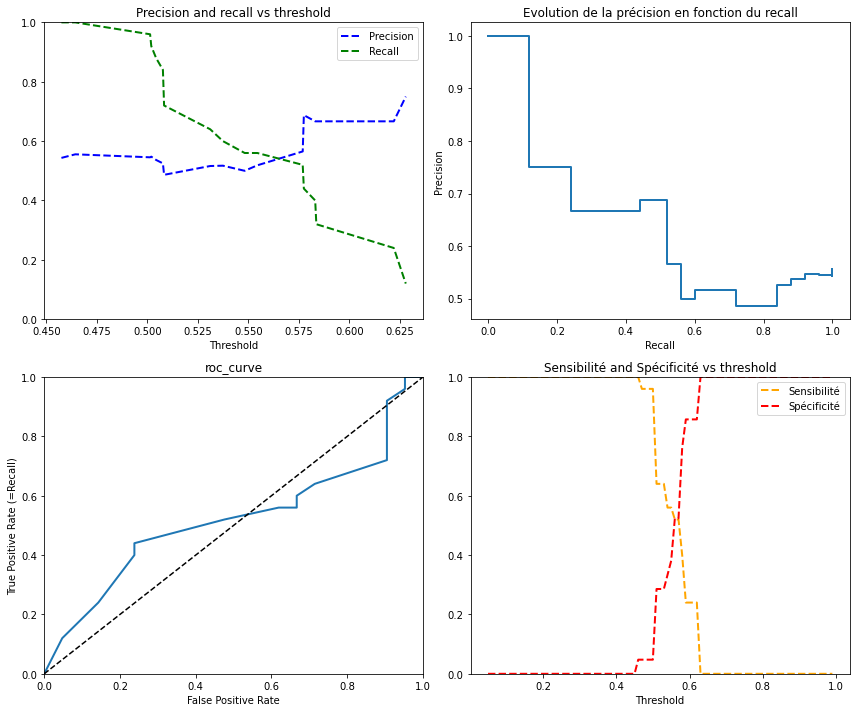

threshold = 0,5
Sensibilité :  0.96
Spécificité :  0.047619047619047616
_________________________________________________________
Best threshold : 0.59
Sensibilité : 0.24
Spécificité : 0.8571428571428571


In [24]:
tree_1_opti_sensi = XGBClassifier(random_state=seed)
gs_sensi = BayesSearchCV(tree_1_opti_sensi, param1, scoring=sensibilite, random_state=seed)
gs_sensi.fit(X_train.loc[:,liste_col_sensi], y_train)
tree_opti_bl_sensi = XGBClassifier(**dict(gs_sensi.best_params_),random_state=seed)
tree_opti_bl_sensi.fit(X_train.loc[:,liste_col_sensi], y_train)
# Results :
pred_bl_sensi = tree_opti_bl_sensi.predict(X_test.loc[:,liste_col_sensi])
model_to_plot(tree_opti_bl_sensi, X_test.loc[:,liste_col_sensi], y_test)
resultat_bl_sensi = pd.DataFrame(pd.Series(scores(y_test, pred_bl_sensi)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_bl_sensi.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_bl_sensi.loc['specificité','XGB_BL_sensi'])
dict_bl_sensi = from_model_to_bst_trhld(tree_opti_bl_sensi, X_test.loc[:,liste_col_sensi], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_bl_sensi['best_threshold'])
print('Sensibilité :', dict_bl_sensi['scores']['sensibilite'])
print('Spécificité :', dict_bl_sensi['scores']['specificité'])

##### Spéci :

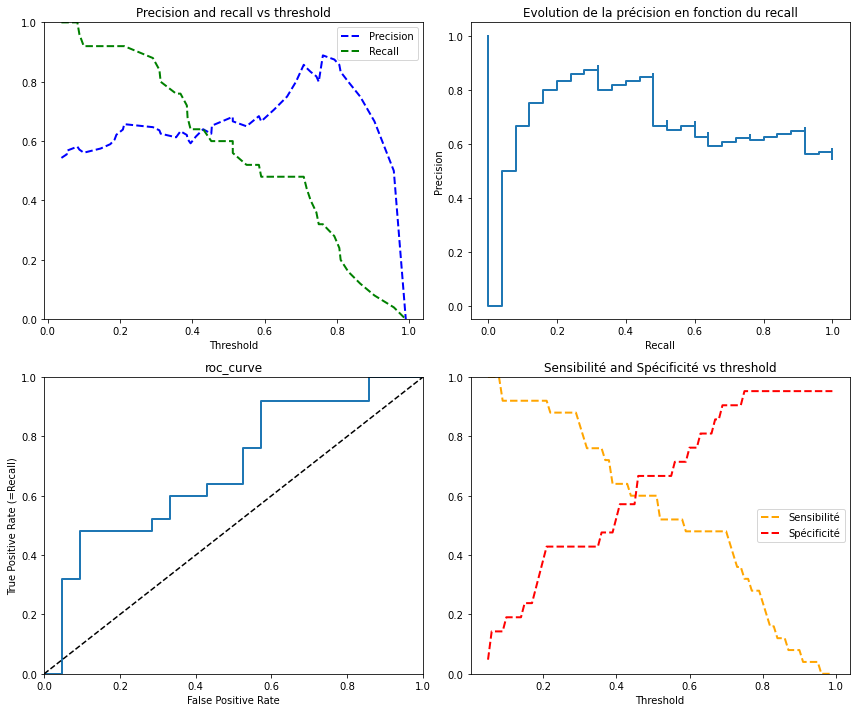

threshold = 0,5
Sensibilité :  0.6
Spécificité :  0.6666666666666666
_________________________________________________________
Best threshold : 0.69
Sensibilité : 0.48
Spécificité : 0.9047619047619048


In [25]:
tree_2_opti_sensi = XGBClassifier(random_state=seed)
gs_sensi2 = BayesSearchCV(tree_2_opti_sensi, param1, scoring=specificite, random_state=seed)
gs_sensi2.fit(X_train.loc[:,liste_col_sensi], y_train)
tree_opti_sensi2 = XGBClassifier(**dict(gs_sensi2.best_params_),random_state=seed)
tree_opti_sensi2.fit(X_train.loc[:,liste_col_sensi], y_train)
# Results :
pred_sensi2 = tree_opti_sensi2.predict(X_test.loc[:,liste_col_sensi])
model_to_plot(tree_opti_sensi2, X_test.loc[:,liste_col_sensi], y_test)
resultat_sensi2 = pd.DataFrame(pd.Series(scores(y_test, pred_sensi2)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi2.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi2.loc['specificité','XGB_BL_sensi'])
dict_sensi2 = from_model_to_bst_trhld(tree_opti_sensi2, X_test.loc[:,liste_col_sensi], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi2['best_threshold'])
print('Sensibilité :', dict_sensi2['scores']['sensibilite'])
print('Spécificité :', dict_sensi2['scores']['specificité'])

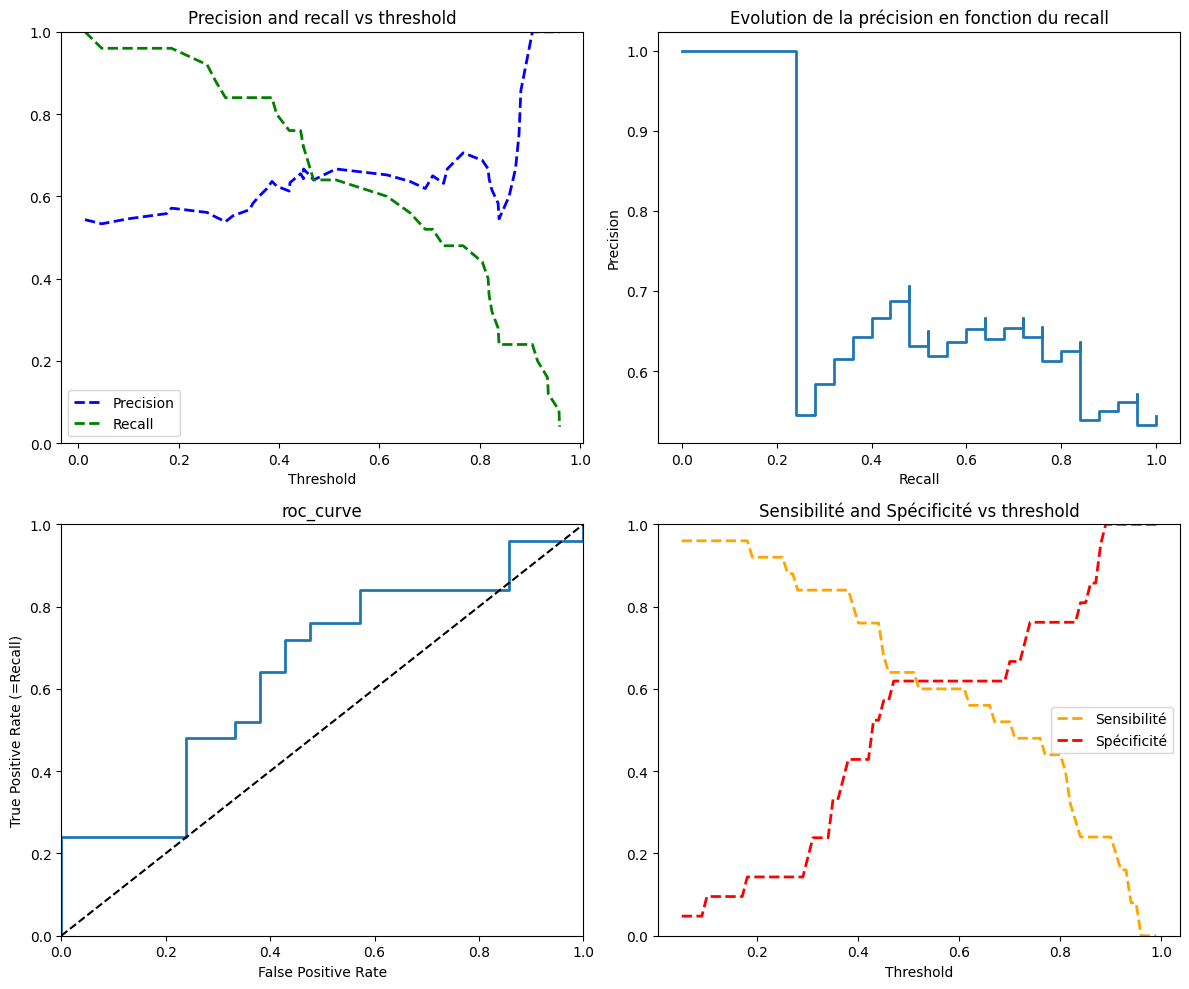

threshold = 0,5
Sensibilité :  0.64
Spécificité :  0.6190476190476191
_________________________________________________________
Best threshold : 0.89
Sensibilité : 0.24
Spécificité : 1.0


In [42]:
tree_2_opti_sensi = XGBClassifier(random_state=seed)
gs_sensi2 = BayesSearchCV(tree_2_opti_sensi, param1, scoring=specificite, random_state=seed)
gs_sensi2.fit(X_train.loc[:,liste_col_sensi], y_train)
tree_opti_sensi2 = XGBClassifier(**dict(gs_sensi2.best_params_),random_state=seed)
tree_opti_sensi2.fit(X_train.loc[:,liste_col_sensi], y_train)
# Results :
pred_sensi2 = tree_opti_sensi2.predict(X_test.loc[:,liste_col_sensi])
model_to_plot(tree_opti_sensi2, X_test.loc[:,liste_col_sensi], y_test)
resultat_sensi2 = pd.DataFrame(pd.Series(scores(y_test, pred_sensi2)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi2.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi2.loc['specificité','XGB_BL_sensi'])
dict_sensi2 = from_model_to_bst_trhld(tree_opti_sensi2, X_test.loc[:,liste_col_sensi], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi2['best_threshold'])
print('Sensibilité :', dict_sensi2['scores']['sensibilite'])
print('Spécificité :', dict_sensi2['scores']['specificité'])

##### F1 :

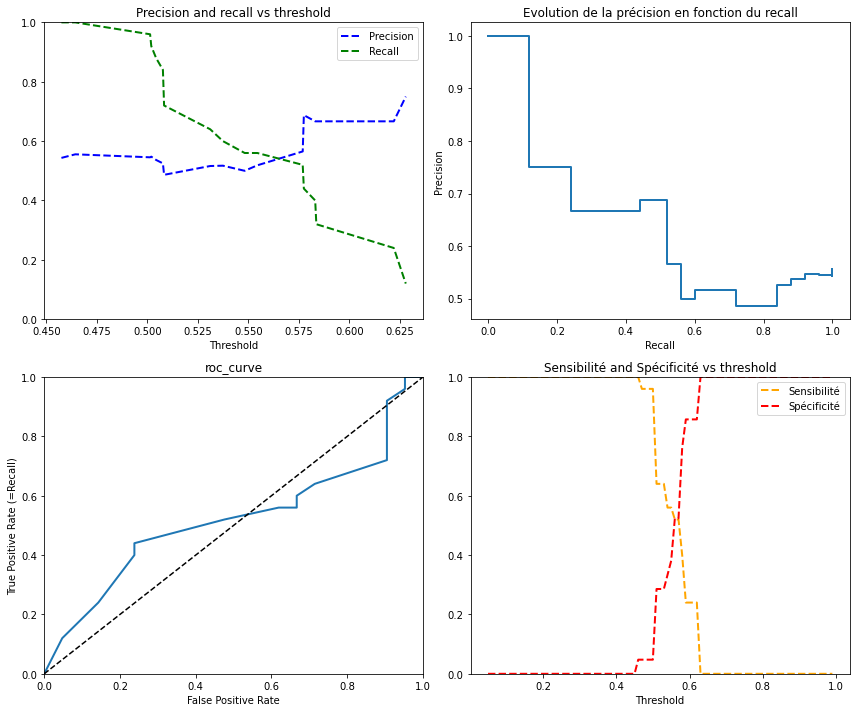

threshold = 0,5
Sensibilité :  0.96
Spécificité :  0.047619047619047616
_________________________________________________________
Best threshold : 0.59
Sensibilité : 0.24
Spécificité : 0.8571428571428571


In [26]:
tree_3_opti_sensi = XGBClassifier(random_state=seed)
gs_sensi3 = BayesSearchCV(tree_3_opti_sensi, param1, scoring='f1', random_state=seed)
gs_sensi3.fit(X_train.loc[:,liste_col_sensi], y_train)
tree_opti_sensi3 = XGBClassifier(**dict(gs_sensi3.best_params_),random_state=seed)
tree_opti_sensi3.fit(X_train.loc[:,liste_col_sensi], y_train)
# Results :
pred_sensi3 = tree_opti_sensi3.predict(X_test.loc[:,liste_col_sensi])
model_to_plot(tree_opti_sensi3, X_test.loc[:,liste_col_sensi], y_test)
resultat_sensi3 = pd.DataFrame(pd.Series(scores(y_test, pred_sensi3)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi3.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi3.loc['specificité','XGB_BL_sensi'])
dict_sensi3 = from_model_to_bst_trhld(tree_opti_sensi3, X_test.loc[:,liste_col_sensi], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi3['best_threshold'])
print('Sensibilité :', dict_sensi3['scores']['sensibilite'])
print('Spécificité :', dict_sensi3['scores']['specificité'])

##### Custom :

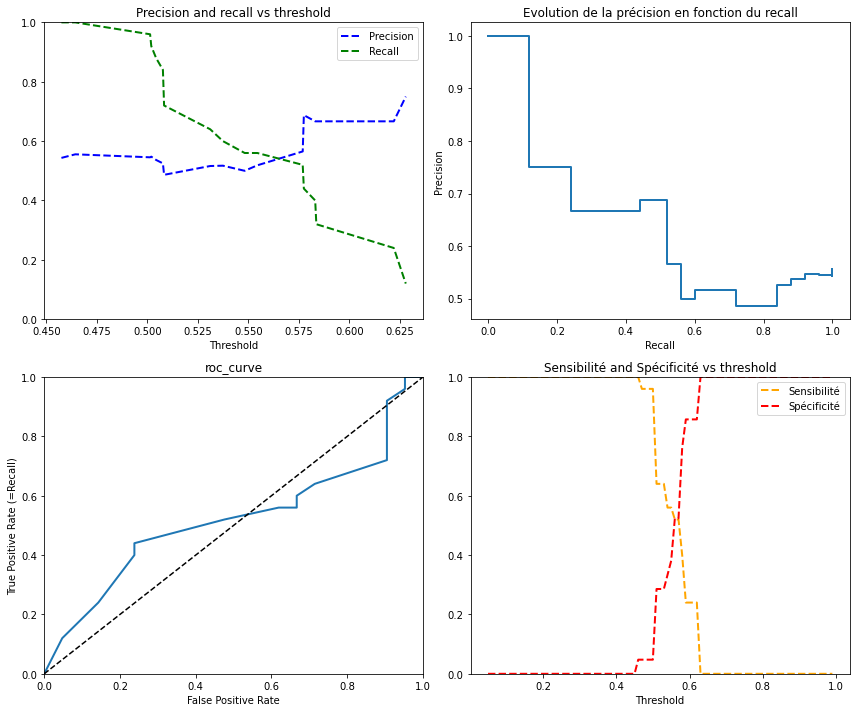

threshold = 0,5
Sensibilité :  0.96
Spécificité :  0.047619047619047616
_________________________________________________________
Best threshold : 0.59
Sensibilité : 0.24
Spécificité : 0.8571428571428571


In [27]:
tree_4_opti_sensi = XGBClassifier(random_state=seed)
gs_sensi4 = BayesSearchCV(tree_4_opti_sensi, param1, scoring=scorer, random_state=seed)
gs_sensi4.fit(X_train.loc[:,liste_col_sensi], y_train)
tree_opti_sensi4 = XGBClassifier(**dict(gs_sensi4.best_params_),random_state=seed)
tree_opti_sensi4.fit(X_train.loc[:,liste_col_sensi], y_train)
# Results :
pred_sensi4 = tree_opti_sensi4.predict(X_test.loc[:,liste_col_sensi])
model_to_plot(tree_opti_sensi4, X_test.loc[:,liste_col_sensi], y_test)
resultat_sensi4 = pd.DataFrame(pd.Series(scores(y_test, pred_sensi4)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi4.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi4.loc['specificité','XGB_BL_sensi'])
dict_sensi4 = from_model_to_bst_trhld(tree_opti_sensi4, X_test.loc[:,liste_col_sensi], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi4['best_threshold'])
print('Sensibilité :', dict_sensi4['scores']['sensibilite'])
print('Spécificité :', dict_sensi4['scores']['specificité'])

##### Average precision :

C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


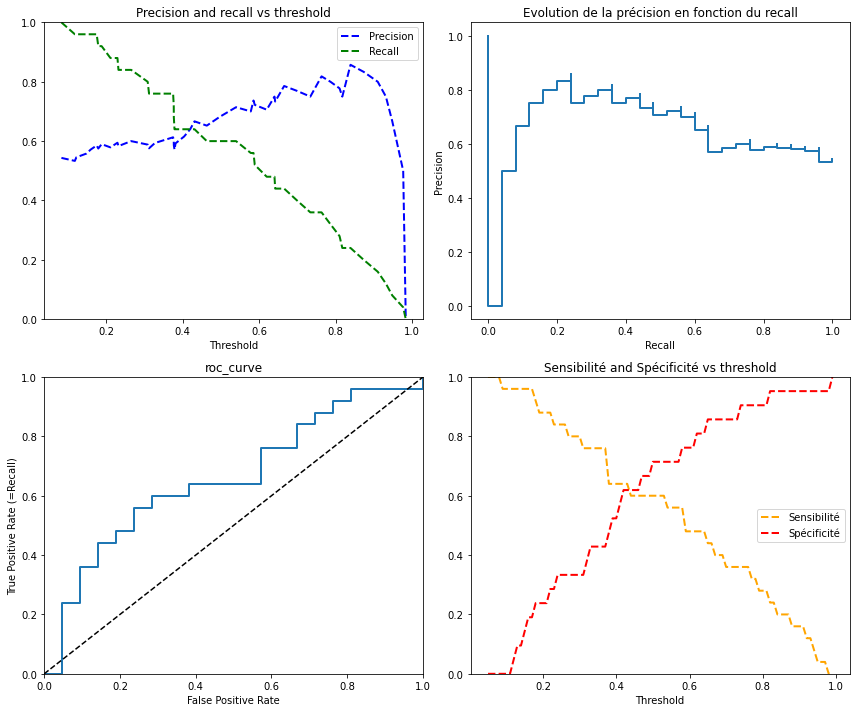

threshold = 0,5
Sensibilité :  0.6
Spécificité :  0.7142857142857143
_________________________________________________________
Best threshold : 0.62
Sensibilité : 0.48
Spécificité : 0.8095238095238095


In [28]:
tree_6_opti_sensi = XGBClassifier(random_state=seed)
gs_sensi6 = BayesSearchCV(tree_6_opti_sensi, param1, scoring='average_precision', random_state=seed)
gs_sensi6.fit(X_train.loc[:,liste_col_sensi], y_train)
tree_opti_sensi6 = XGBClassifier(**dict(gs_sensi6.best_params_),random_state=seed)
tree_opti_sensi6.fit(X_train.loc[:,liste_col_sensi], y_train)
# Results :
pred_sensi6 = tree_opti_sensi6.predict(X_test.loc[:,liste_col_sensi])
model_to_plot(tree_opti_sensi6, X_test.loc[:,liste_col_sensi], y_test)
resultat_sensi6 = pd.DataFrame(pd.Series(scores(y_test, pred_sensi6)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi6.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi6.loc['specificité','XGB_BL_sensi'])
dict_sensi6 = from_model_to_bst_trhld(tree_opti_sensi6, X_test.loc[:,liste_col_sensi], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi6['best_threshold'])
print('Sensibilité :', dict_sensi6['scores']['sensibilite'])
print('Spécificité :', dict_sensi6['scores']['specificité'])

##### Mix :

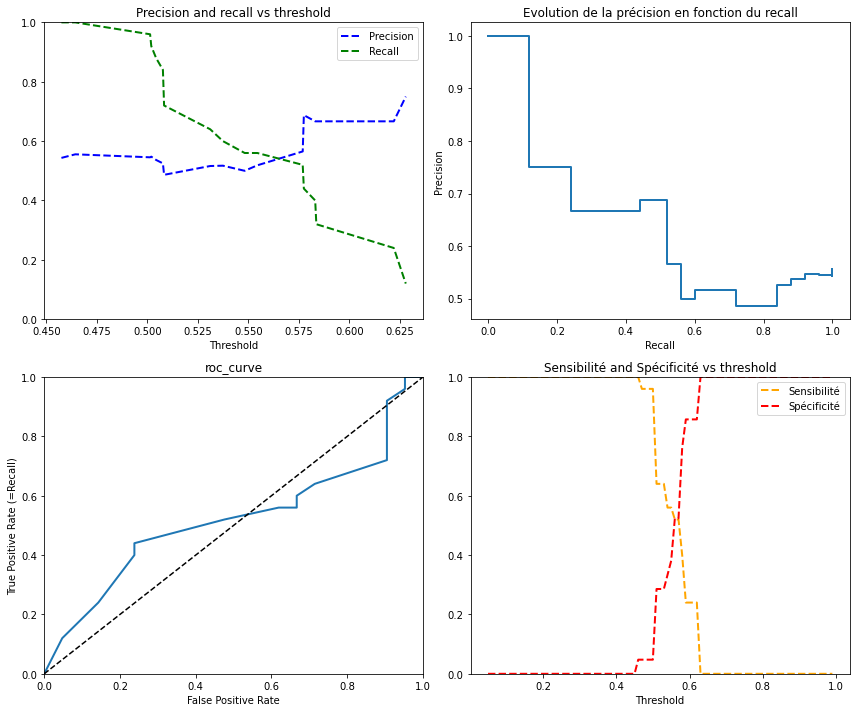

threshold = 0,5
Sensibilité :  0.96
Spécificité :  0.047619047619047616
_________________________________________________________
Best threshold : 0.59
Sensibilité : 0.24
Spécificité : 0.8571428571428571


In [29]:
tree_5_opti_sensi = XGBClassifier(random_state=seed)
gs_sensi5 = BayesSearchCV(tree_5_opti_sensi, param1, scoring=mix_recall, random_state=seed)
gs_sensi5.fit(X_train.loc[:,liste_col_sensi], y_train)
tree_opti_sensi5 = XGBClassifier(**dict(gs_sensi5.best_params_),random_state=seed)
tree_opti_sensi5.fit(X_train.loc[:,liste_col_sensi], y_train)
# Results :
pred_sensi5 = tree_opti_sensi5.predict(X_test.loc[:,liste_col_sensi])
model_to_plot(tree_opti_sensi5, X_test.loc[:,liste_col_sensi], y_test)
resultat_sensi5 = pd.DataFrame(pd.Series(scores(y_test, pred_sensi5)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi5.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi5.loc['specificité','XGB_BL_sensi'])
dict_sensi5 = from_model_to_bst_trhld(tree_opti_sensi5, X_test.loc[:,liste_col_sensi], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi5['best_threshold'])
print('Sensibilité :', dict_sensi5['scores']['sensibilite'])
print('Spécificité :', dict_sensi5['scores']['specificité'])

## ML speci

### Base line : 

In [30]:
XGB_speci = XGBClassifier(random_state=seed)
XGB_speci_cv = cross_validate(XGB_speci, X_train.loc[:,liste_col_speci], y_train, cv=5, scoring=scorers, return_estimator =True)

print('sensi : ',round(XGB_speci_cv['test_sensi'].mean(), 2))
print('speci : ',round(XGB_speci_cv['test_speci'].mean(),2))

sensi :  0.67
speci :  0.64


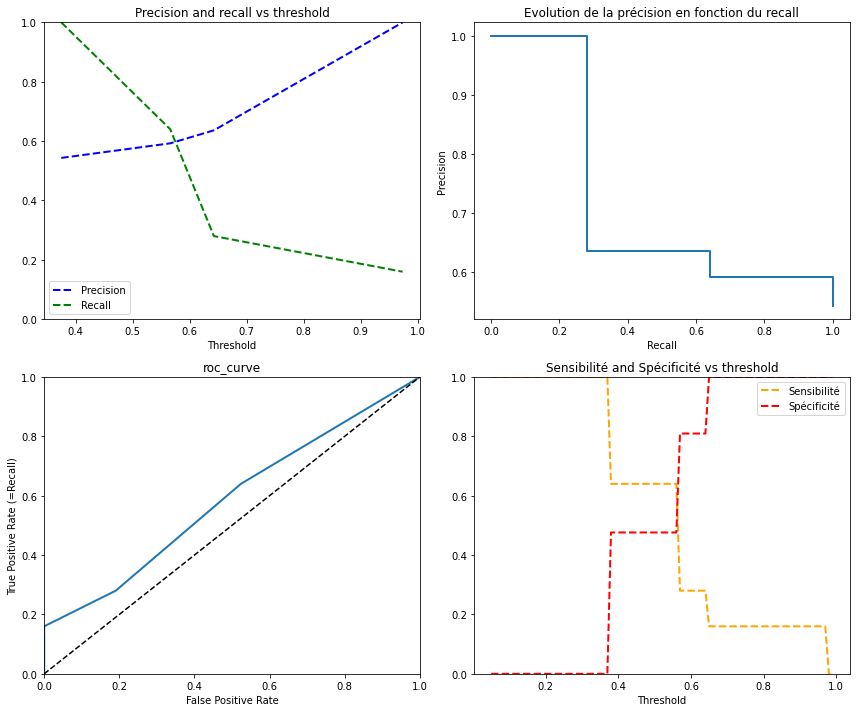

threshold = 0,5
Sensibilité :  0.64
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.57
Sensibilité : 0.28
Spécificité : 0.8095238095238095


In [31]:
tree_BL_sensi = XGBClassifier(random_state=seed)
tree_BL_sensi.fit(X_train.loc[:,liste_col_speci], y_train)
pred_BL_sensi = tree_BL_sensi.predict(X_test.loc[:,liste_col_speci])
model_to_plot(tree_BL_sensi, X_test.loc[:,liste_col_speci], y_test)
resultat_BL_sensi = pd.DataFrame(pd.Series(scores(y_test, pred_BL_sensi)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_BL_sensi.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_BL_sensi.loc['specificité','XGB_BL_sensi'])
dict_sensi = from_model_to_bst_trhld(tree_BL_sensi, X_test.loc[:,liste_col_speci], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi['best_threshold'])
print('Sensibilité :', dict_sensi['scores']['sensibilite'])
print('Spécificité :', dict_sensi['scores']['specificité'])

### Optimisation : 

##### Sensibilité :

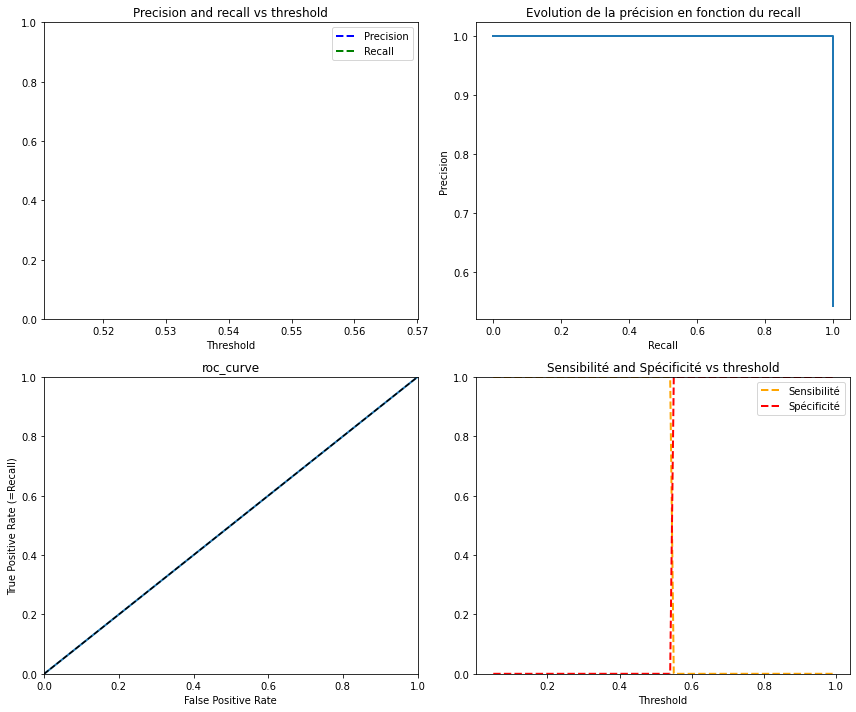

threshold = 0,5
Sensibilité :  1.0
Spécificité :  0.0
_________________________________________________________
Best threshold : 0.55
Sensibilité : 0.0
Spécificité : 1.0


In [32]:
tree_1_opti_speci = XGBClassifier(random_state=seed)
gs_speci = BayesSearchCV(tree_1_opti_speci, param1, scoring=sensibilite, random_state=seed)
gs_speci.fit(X_train.loc[:,liste_col_speci], y_train)
tree_opti_speci1 = XGBClassifier(**dict(gs_speci.best_params_),random_state=seed)
tree_opti_speci1.fit(X_train.loc[:,liste_col_speci], y_train)
# Results :
pred_speci_1 = tree_opti_speci1.predict(X_test.loc[:,liste_col_speci])
model_to_plot(tree_opti_speci1, X_test.loc[:,liste_col_speci], y_test)
resultat_speci_1 = pd.DataFrame(pd.Series(scores(y_test, pred_speci_1)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_speci_1.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_speci_1.loc['specificité','XGB_BL_sensi'])
dict_speci_1 = from_model_to_bst_trhld(tree_opti_speci1, X_test.loc[:,liste_col_speci], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_speci_1['best_threshold'])
print('Sensibilité :', dict_speci_1['scores']['sensibilite'])
print('Spécificité :', dict_speci_1['scores']['specificité'])

##### Spéci :

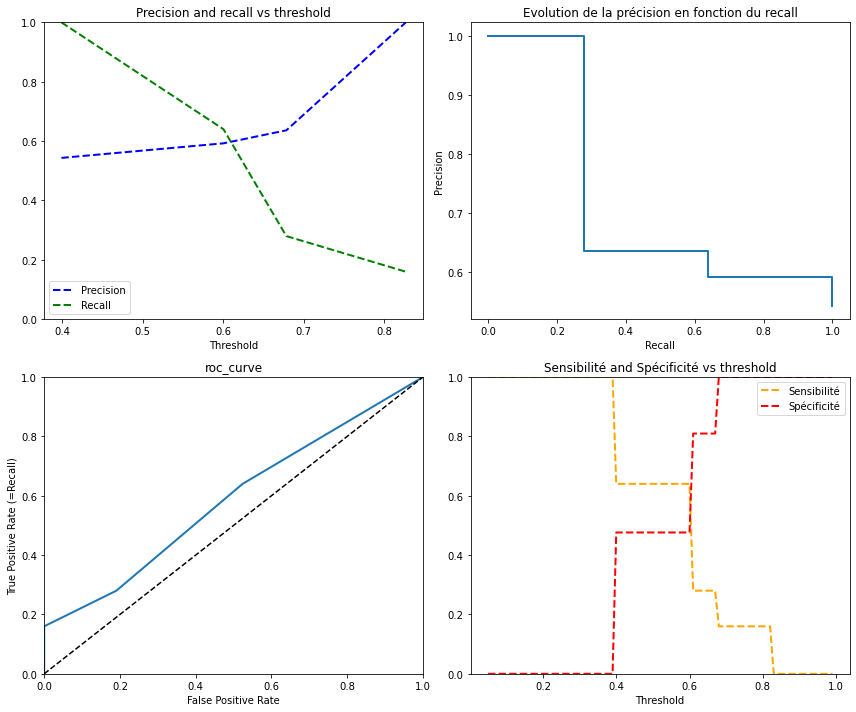

threshold = 0,5
Sensibilité :  0.64
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.61
Sensibilité : 0.28
Spécificité : 0.8095238095238095


In [33]:
tree_2_opti_speci = XGBClassifier(random_state=seed)
gs_speci2 = BayesSearchCV(tree_2_opti_speci, param1, scoring=specificite, random_state=seed)
gs_speci2.fit(X_train.loc[:,liste_col_speci], y_train)
tree_opti_speci2 = XGBClassifier(**dict(gs_speci2.best_params_),random_state=seed)
tree_opti_speci2.fit(X_train.loc[:,liste_col_speci], y_train)
# Results :
pred_speci_2 = tree_opti_speci2.predict(X_test.loc[:,liste_col_speci])
model_to_plot(tree_opti_speci2, X_test.loc[:,liste_col_speci], y_test)
resultat_speci_2 = pd.DataFrame(pd.Series(scores(y_test, pred_speci_2)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_speci_2.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_speci_2.loc['specificité','XGB_BL_sensi'])
dict_speci_2 = from_model_to_bst_trhld(tree_opti_speci2, X_test.loc[:,liste_col_speci], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_speci_2['best_threshold'])
print('Sensibilité :', dict_speci_2['scores']['sensibilite'])
print('Spécificité :', dict_speci_2['scores']['specificité'])

##### F1 :

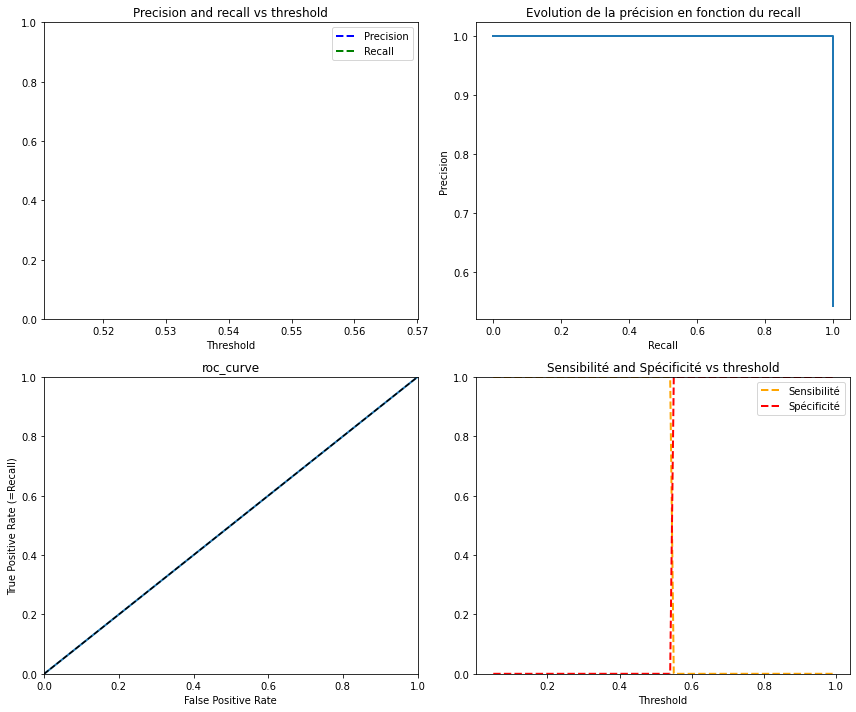

threshold = 0,5
Sensibilité :  1.0
Spécificité :  0.0
_________________________________________________________
Best threshold : 0.55
Sensibilité : 0.0
Spécificité : 1.0


In [34]:
tree_3_opti_speci = XGBClassifier(random_state=seed)
gs_speci3 = BayesSearchCV(tree_3_opti_speci, param1, scoring=('f1'), random_state=seed)
gs_speci3.fit(X_train.loc[:,liste_col_speci], y_train)
tree_opti_speci3 = XGBClassifier(**dict(gs_speci3.best_params_),random_state=seed)
tree_opti_speci3.fit(X_train.loc[:,liste_col_speci], y_train)
# Results :
pred_speci_3 = tree_opti_speci3.predict(X_test.loc[:,liste_col_speci])
model_to_plot(tree_opti_speci3, X_test.loc[:,liste_col_speci], y_test)
resultat_speci_3 = pd.DataFrame(pd.Series(scores(y_test, pred_speci_3)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_speci_3.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_speci_3.loc['specificité','XGB_BL_sensi'])
dict_speci_3 = from_model_to_bst_trhld(tree_opti_speci3, X_test.loc[:,liste_col_speci], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_speci_3['best_threshold'])
print('Sensibilité :', dict_speci_3['scores']['sensibilite'])
print('Spécificité :', dict_speci_3['scores']['specificité'])

##### Custom :

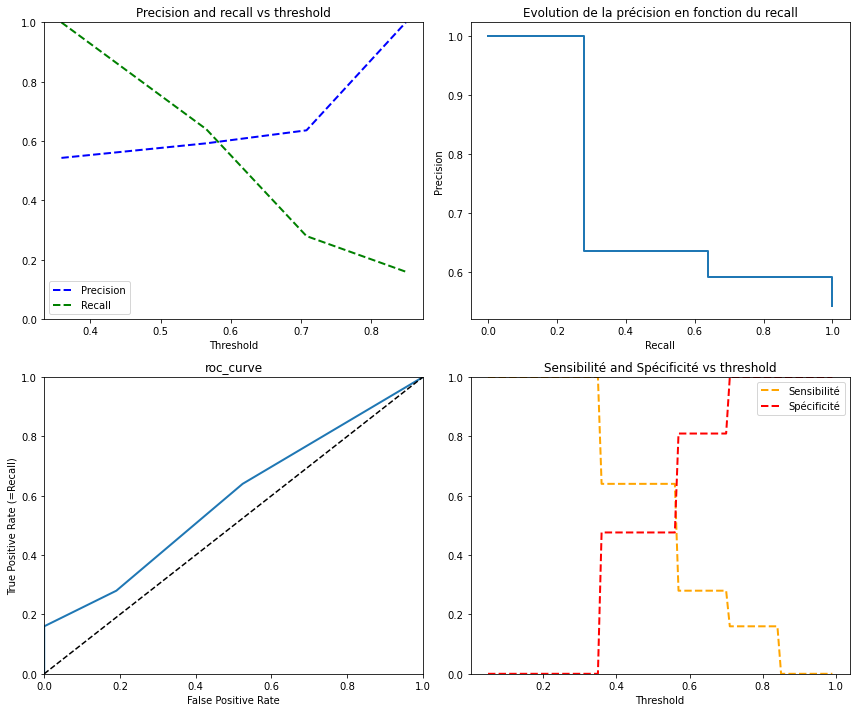

threshold = 0,5
Sensibilité :  0.64
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.57
Sensibilité : 0.28
Spécificité : 0.8095238095238095


In [35]:
tree_4_opti_speci = XGBClassifier(random_state=seed)
gs_speci4 = BayesSearchCV(tree_4_opti_speci, param1, scoring=scorer, random_state=seed)
gs_speci4.fit(X_train.loc[:,liste_col_speci], y_train)
tree_opti_speci4 = XGBClassifier(**dict(gs_speci4.best_params_),random_state=seed)
tree_opti_speci4.fit(X_train.loc[:,liste_col_speci], y_train)
# Results :
pred_speci_4 = tree_opti_speci4.predict(X_test.loc[:,liste_col_speci])
model_to_plot(tree_opti_speci4, X_test.loc[:,liste_col_speci], y_test)
resultat_speci_4 = pd.DataFrame(pd.Series(scores(y_test, pred_speci_4)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_speci_4.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_speci_4.loc['specificité','XGB_BL_sensi'])
dict_speci_4 = from_model_to_bst_trhld(tree_opti_speci4, X_test.loc[:,liste_col_speci], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_speci_4['best_threshold'])
print('Sensibilité :', dict_speci_4['scores']['sensibilite'])
print('Spécificité :', dict_speci_4['scores']['specificité'])

##### Mix :

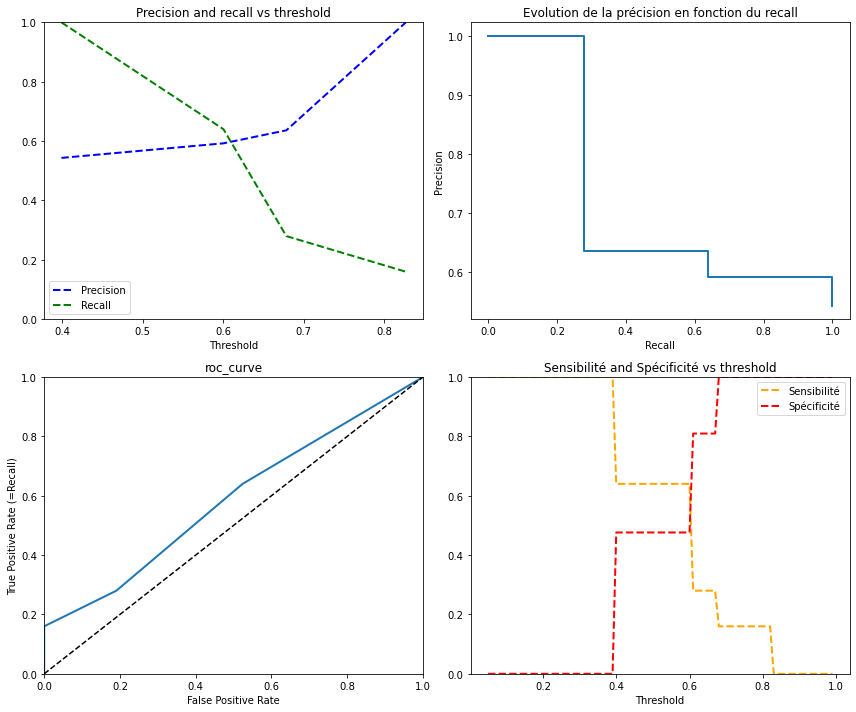

threshold = 0,5
Sensibilité :  0.64
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.61
Sensibilité : 0.28
Spécificité : 0.8095238095238095


In [36]:
tree_5_opti_speci = XGBClassifier(random_state=seed)
gs_speci5 = BayesSearchCV(tree_5_opti_speci, param1, scoring=mix_recall, random_state=seed)
gs_speci5.fit(X_train.loc[:,liste_col_speci], y_train)
tree_opti_speci_5 = XGBClassifier(**dict(gs_speci5.best_params_),random_state=seed)
tree_opti_speci_5.fit(X_train.loc[:,liste_col_speci], y_train)
# Results :
pred_speci_5 = tree_opti_speci_5.predict(X_test.loc[:,liste_col_speci])
model_to_plot(tree_opti_speci_5, X_test.loc[:,liste_col_speci], y_test)
resultat_speci_5 = pd.DataFrame(pd.Series(scores(y_test, pred_speci_5)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_speci_5.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_speci_5.loc['specificité','XGB_BL_sensi'])
dict_speci_5 = from_model_to_bst_trhld(tree_opti_speci_5, X_test.loc[:,liste_col_speci], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_speci_5['best_threshold'])
print('Sensibilité :', dict_speci_5['scores']['sensibilite'])
print('Spécificité :', dict_speci_5['scores']['specificité'])

##### average precision :

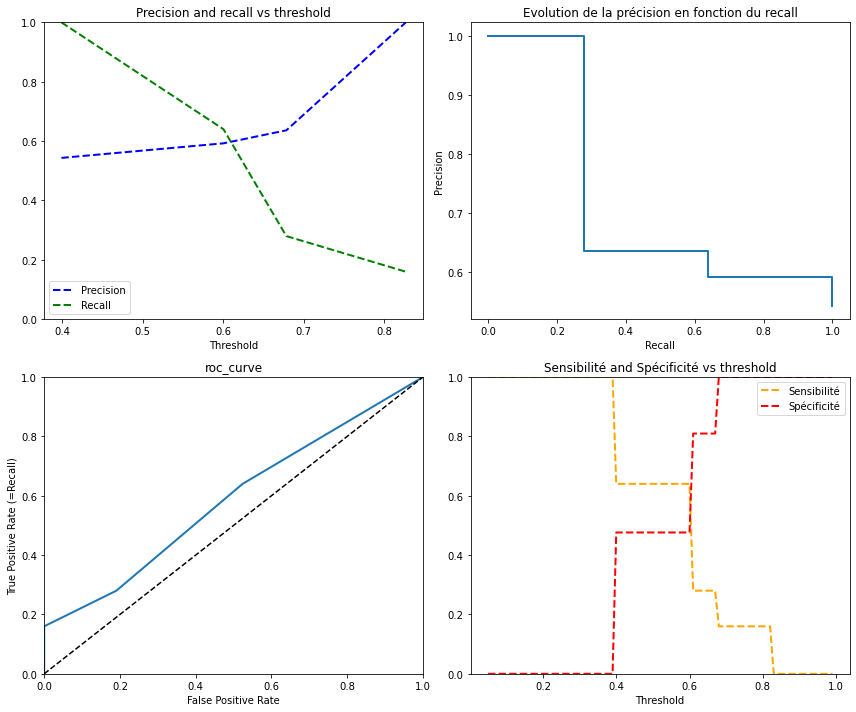

threshold = 0,5
Sensibilité :  0.64
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.61
Sensibilité : 0.28
Spécificité : 0.8095238095238095


In [37]:
tree_6_opti_speci = XGBClassifier(random_state=seed)
gs_speci6 = BayesSearchCV(tree_6_opti_speci, param1, scoring=mix_recall, random_state=seed)
gs_speci6.fit(X_train.loc[:,liste_col_speci], y_train)
tree_opti_speci6 = XGBClassifier(**dict(gs_speci6.best_params_),random_state=seed)
tree_opti_speci6.fit(X_train.loc[:,liste_col_speci], y_train)
# Results :
pred_speci_6 = tree_opti_speci6.predict(X_test.loc[:,liste_col_speci])
model_to_plot(tree_opti_speci6, X_test.loc[:,liste_col_speci], y_test)
resultat_speci_6 = pd.DataFrame(pd.Series(scores(y_test, pred_speci_6)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_speci_6.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_speci_6.loc['specificité','XGB_BL_sensi'])
dict_speci_6 = from_model_to_bst_trhld(tree_opti_speci6, X_test.loc[:,liste_col_speci], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_speci_6['best_threshold'])
print('Sensibilité :', dict_speci_6['scores']['sensibilite'])
print('Spécificité :', dict_speci_6['scores']['specificité'])

## ML mixte : 

### Base line : 

In [38]:
XGB_mixte = XGBClassifier(random_state=seed)
XGB_mixte_cv = cross_validate(XGB_speci, X_train.loc[:,liste_col_mixte], y_train, cv=5, scoring=scorers, return_estimator =True)

print('sensi : ',round(XGB_mixte_cv['test_sensi'].mean(), 2))
print('speci : ',round(XGB_mixte_cv['test_speci'].mean(),2))

sensi :  0.56
speci :  0.59


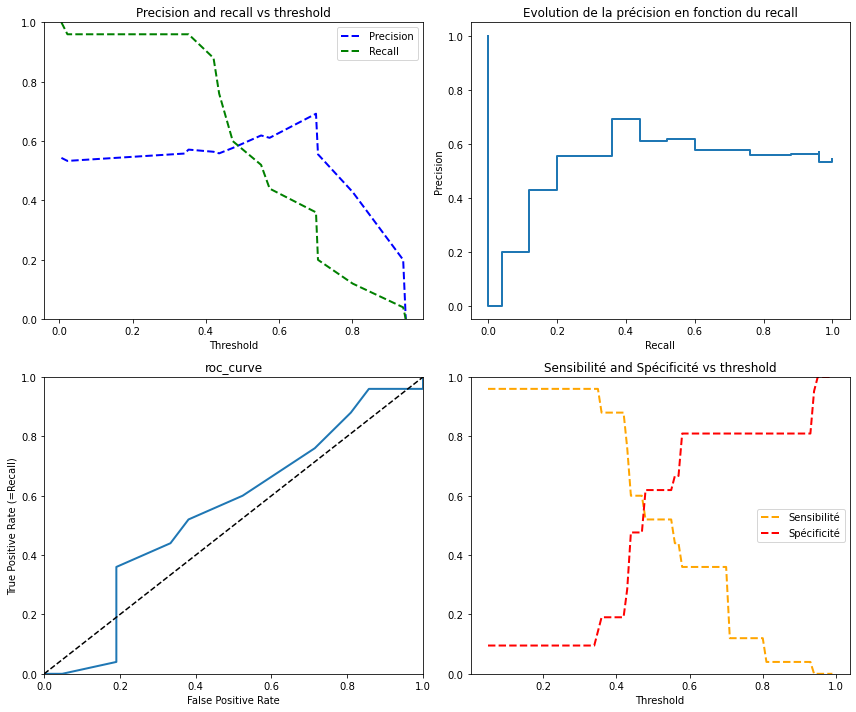

threshold = 0,5
Sensibilité :  0.52
Spécificité :  0.6190476190476191
_________________________________________________________
Best threshold : 0.58
Sensibilité : 0.36
Spécificité : 0.8095238095238095


In [39]:
tree_BL_sensi = XGBClassifier(random_state=seed)
tree_BL_sensi.fit(X_train.loc[:,liste_col_mixte], y_train)
pred_BL_sensi = tree_BL_sensi.predict(X_test.loc[:,liste_col_mixte])
model_to_plot(tree_BL_sensi, X_test.loc[:,liste_col_mixte], y_test)
resultat_BL_sensi = pd.DataFrame(pd.Series(scores(y_test, pred_BL_sensi)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_BL_sensi.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_BL_sensi.loc['specificité','XGB_BL_sensi'])
dict_sensi = from_model_to_bst_trhld(tree_BL_sensi, X_test.loc[:,liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi['best_threshold'])
print('Sensibilité :', dict_sensi['scores']['sensibilite'])
print('Spécificité :', dict_sensi['scores']['specificité'])

### Optimisation : 

##### Sensibilité :

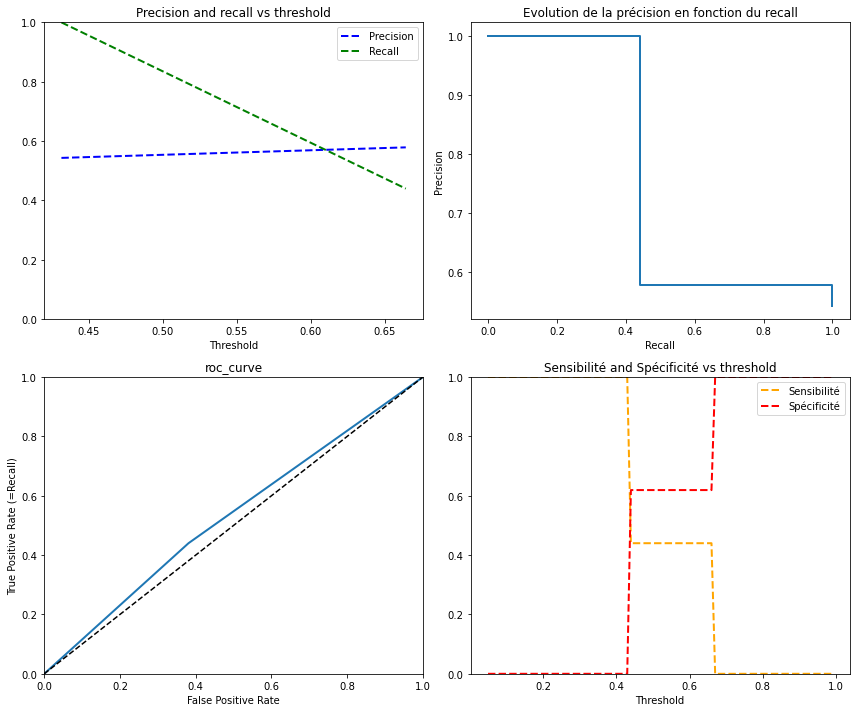

threshold = 0,5
Sensibilité :  0.44
Spécificité :  0.6190476190476191
_________________________________________________________
Best threshold : 0.67
Sensibilité : 0.0
Spécificité : 1.0


In [40]:
tree_1_opti_mixte = XGBClassifier(random_state=seed)
gs_mixte = BayesSearchCV(tree_1_opti_mixte, param1, scoring=sensibilite, random_state=seed)
gs_mixte.fit(X_train.loc[:,liste_col_mixte], y_train)
tree_opti_mixte_1 = XGBClassifier(**dict(gs_mixte.best_params_),random_state=seed)
tree_opti_mixte_1.fit(X_train.loc[:,liste_col_mixte], y_train)
# Results :
pred_mixte_1 = tree_opti_mixte_1.predict(X_test.loc[:,liste_col_mixte])
model_to_plot(tree_opti_mixte_1, X_test.loc[:,liste_col_mixte], y_test)
resultat_mixte_1 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_1)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_1.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_1.loc['specificité','XGB_BL_sensi'])
dict_mixte_1 = from_model_to_bst_trhld(tree_opti_mixte_1, X_test.loc[:,liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_1['best_threshold'])
print('Sensibilité :', dict_mixte_1['scores']['sensibilite'])
print('Spécificité :', dict_mixte_1['scores']['specificité'])

##### Spéci :

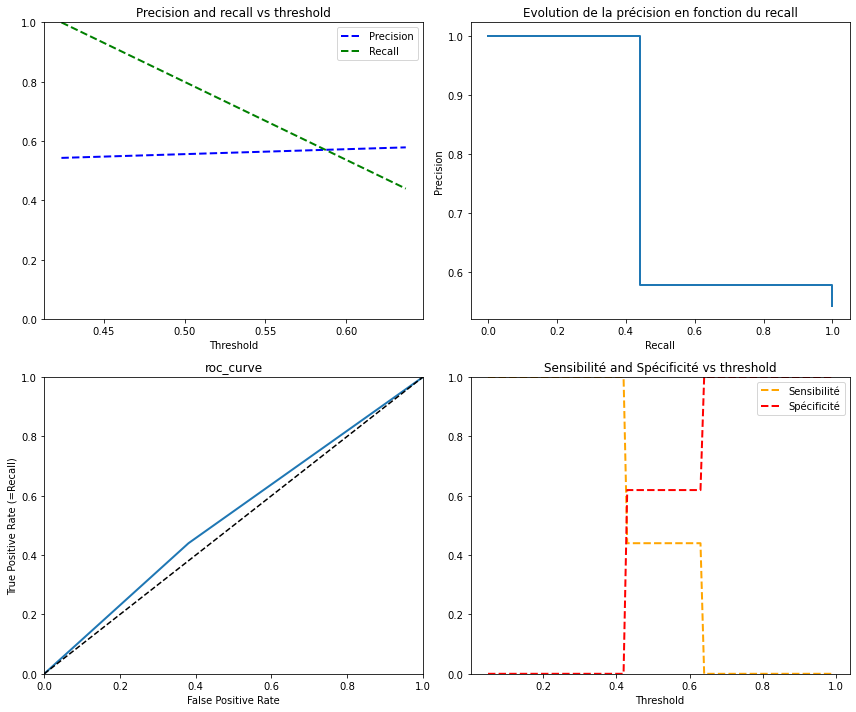

threshold = 0,5
Sensibilité :  0.44
Spécificité :  0.6190476190476191
_________________________________________________________
Best threshold : 0.64
Sensibilité : 0.0
Spécificité : 1.0


In [41]:
tree_2_opti_mixte = XGBClassifier()
gs_mixte2 = BayesSearchCV(tree_2_opti_mixte, param1, scoring=specificite, random_state=seed)
gs_mixte2.fit(X_train.loc[:,liste_col_mixte], y_train)
tree_opti_mixte_2 = XGBClassifier(**dict(gs_mixte2.best_params_),random_state=seed)
tree_opti_mixte_2.fit(X_train.loc[:,liste_col_mixte], y_train)
# Results :
pred_mixte_2 = tree_opti_mixte_2.predict(X_test.loc[:,liste_col_mixte])
model_to_plot(tree_opti_mixte_2, X_test.loc[:,liste_col_mixte], y_test)
resultat_mixte_2 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_2)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_2.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_2.loc['specificité','XGB_BL_sensi'])
dict_mixte_2 = from_model_to_bst_trhld(tree_opti_mixte_2, X_test.loc[:,liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_2['best_threshold'])
print('Sensibilité :', dict_mixte_2['scores']['sensibilite'])
print('Spécificité :', dict_mixte_2['scores']['specificité'])

##### F1 :

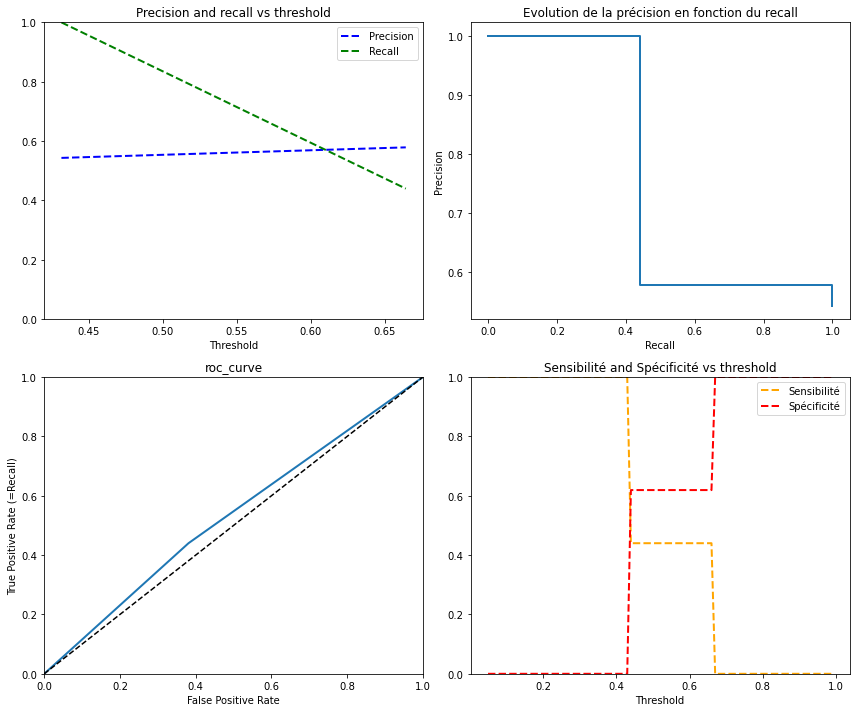

threshold = 0,5
Sensibilité :  0.44
Spécificité :  0.6190476190476191
_________________________________________________________
Best threshold : 0.67
Sensibilité : 0.0
Spécificité : 1.0


In [42]:
tree_3_opti_mixte = XGBClassifier(random_state=seed)
gs_mixte3 = BayesSearchCV(tree_3_opti_mixte, param1, scoring=('f1'), random_state=seed)
gs_mixte3.fit(X_train.loc[:,liste_col_mixte], y_train)
tree_opti_mixte_3 = XGBClassifier(**dict(gs_mixte3.best_params_),random_state=seed)
tree_opti_mixte_3.fit(X_train.loc[:,liste_col_mixte], y_train)
# Results :
pred_mixte_3 = tree_opti_mixte_3.predict(X_test.loc[:,liste_col_mixte])
model_to_plot(tree_opti_mixte_3, X_test.loc[:,liste_col_mixte], y_test)
resultat_mixte_3 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_3)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_3.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_3.loc['specificité','XGB_BL_sensi'])
dict_mixte_3 = from_model_to_bst_trhld(tree_opti_mixte_3, X_test.loc[:,liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_3['best_threshold'])
print('Sensibilité :', dict_mixte_3['scores']['sensibilite'])
print('Spécificité :', dict_mixte_3['scores']['specificité'])

##### Custom :

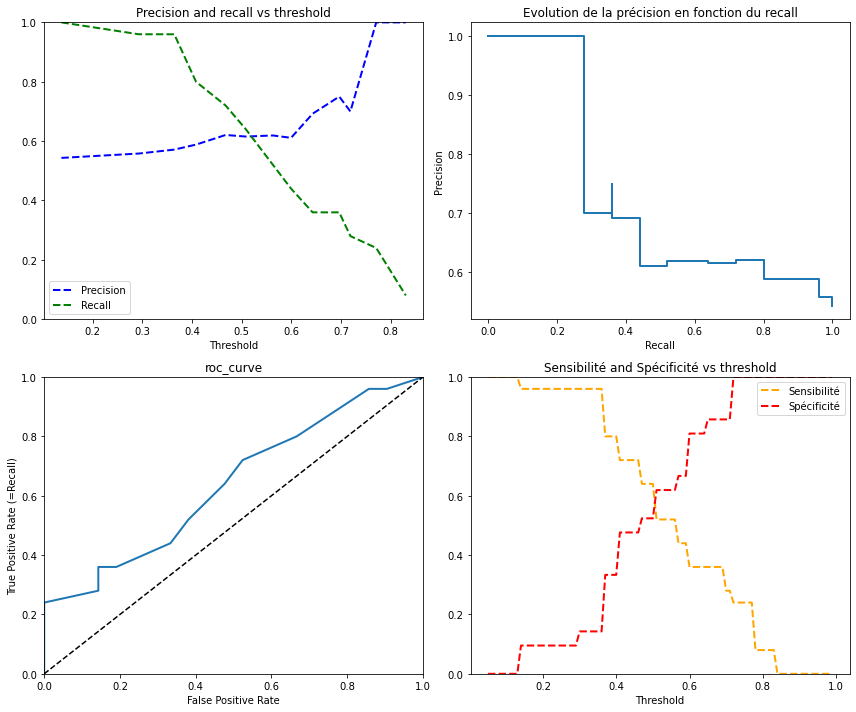

threshold = 0,5
Sensibilité :  0.64
Spécificité :  0.5238095238095238
_________________________________________________________
Best threshold : 0.65
Sensibilité : 0.36
Spécificité : 0.8571428571428571


In [43]:
tree_4_opti_mixte = XGBClassifier(random_state=seed)
gs_mixte4 = BayesSearchCV(tree_4_opti_mixte, param1, scoring=scorer, random_state=seed)
gs_mixte4.fit(X_train.loc[:,liste_col_mixte], y_train)
tree_opti_mixte_4 = XGBClassifier(**dict(gs_mixte4.best_params_),random_state=seed)
tree_opti_mixte_4.fit(X_train.loc[:,liste_col_mixte], y_train)
# Results :
pred_mixte_4 = tree_opti_mixte_4.predict(X_test.loc[:,liste_col_mixte])
model_to_plot(tree_opti_mixte_4, X_test.loc[:,liste_col_mixte], y_test)
resultat_mixte_4 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_4)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_4.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_4.loc['specificité','XGB_BL_sensi'])
dict_mixte_4 = from_model_to_bst_trhld(tree_opti_mixte_4, X_test.loc[:,liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_4['best_threshold'])
print('Sensibilité :', dict_mixte_4['scores']['sensibilite'])
print('Spécificité :', dict_mixte_4['scores']['specificité'])

##### Mix :

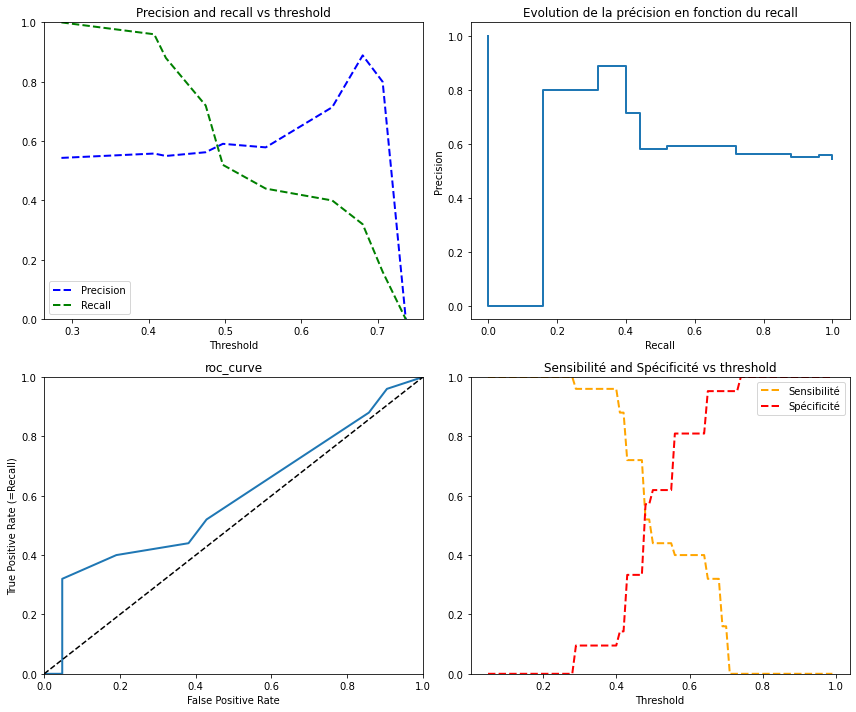

threshold = 0,5
Sensibilité :  0.44
Spécificité :  0.6190476190476191
_________________________________________________________
Best threshold : 0.56
Sensibilité : 0.4
Spécificité : 0.8095238095238095


In [44]:
tree_5_opti_mixte = XGBClassifier(random_state=seed)
gs_mixte5 = BayesSearchCV(tree_5_opti_mixte, param1, scoring=mix_recall, random_state=seed)
gs_mixte5.fit(X_train.loc[:,liste_col_mixte], y_train)
tree_opti_mixte_5 = XGBClassifier(**dict(gs_mixte5.best_params_),random_state=seed)
tree_opti_mixte_5.fit(X_train.loc[:,liste_col_mixte], y_train)
# Results :
pred_mixte_5 = tree_opti_mixte_5.predict(X_test.loc[:,liste_col_mixte])
model_to_plot(tree_opti_mixte_5, X_test.loc[:,liste_col_mixte], y_test)
resultat_mixte_5 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_5)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_5.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_5.loc['specificité','XGB_BL_sensi'])
dict_mixte_5 = from_model_to_bst_trhld(tree_opti_mixte_5, X_test.loc[:,liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_5['best_threshold'])
print('Sensibilité :', dict_mixte_5['scores']['sensibilite'])
print('Spécificité :', dict_mixte_5['scores']['specificité'])

##### Average precision :

C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


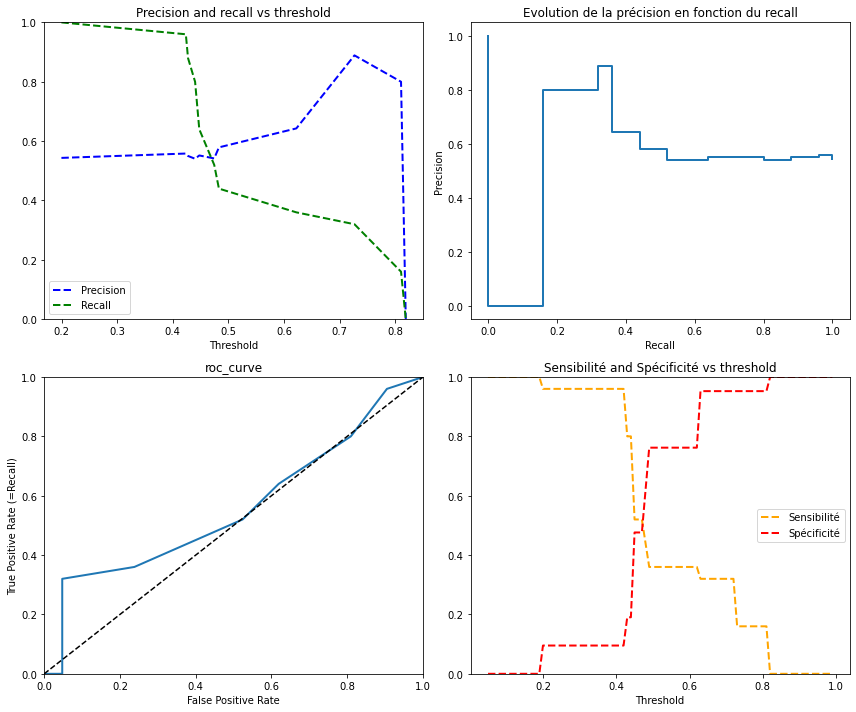

threshold = 0,5
Sensibilité :  0.36
Spécificité :  0.7619047619047619
_________________________________________________________
Best threshold : 0.63
Sensibilité : 0.32
Spécificité : 0.9523809523809523


In [45]:
tree_6_opti_mixte = XGBClassifier(random_state=seed)
gs_mixte6 = BayesSearchCV(tree_6_opti_mixte, param1, scoring='average_precision', random_state=seed)
gs_mixte6.fit(X_train.loc[:,liste_col_mixte], y_train)
tree_opti_mixte_6 = XGBClassifier(**dict(gs_mixte6.best_params_),random_state=seed)
tree_opti_mixte_6.fit(X_train.loc[:,liste_col_mixte], y_train)
# Results :
pred_mixte6 = tree_opti_mixte_6.predict(X_test.loc[:,liste_col_mixte])
model_to_plot(tree_opti_mixte_6, X_test.loc[:,liste_col_mixte], y_test)
resultat_mixte_6 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte6)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_6.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_6.loc['specificité','XGB_BL_sensi'])
dict_mixte_6 = from_model_to_bst_trhld(tree_opti_mixte_6, X_test.loc[:,liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_6['best_threshold'])
print('Sensibilité :', dict_mixte_6['scores']['sensibilite'])
print('Spécificité :', dict_mixte_6['scores']['specificité'])

## ML speci + mixte : 

### Base line : 

In [46]:
XGB_speci_mixte = XGBClassifier(random_state=seed)
XGB_speci_mixte_cv = cross_validate(XGB_speci_mixte, X_train.loc[:,liste_col_speci+liste_col_mixte], y_train, cv=5, scoring=scorers, return_estimator =True)

print('sensi : ',round(XGB_speci_mixte_cv['test_sensi'].mean(), 2))
print('speci : ',round(XGB_speci_mixte_cv['test_speci'].mean(),2))

sensi :  0.58
speci :  0.52


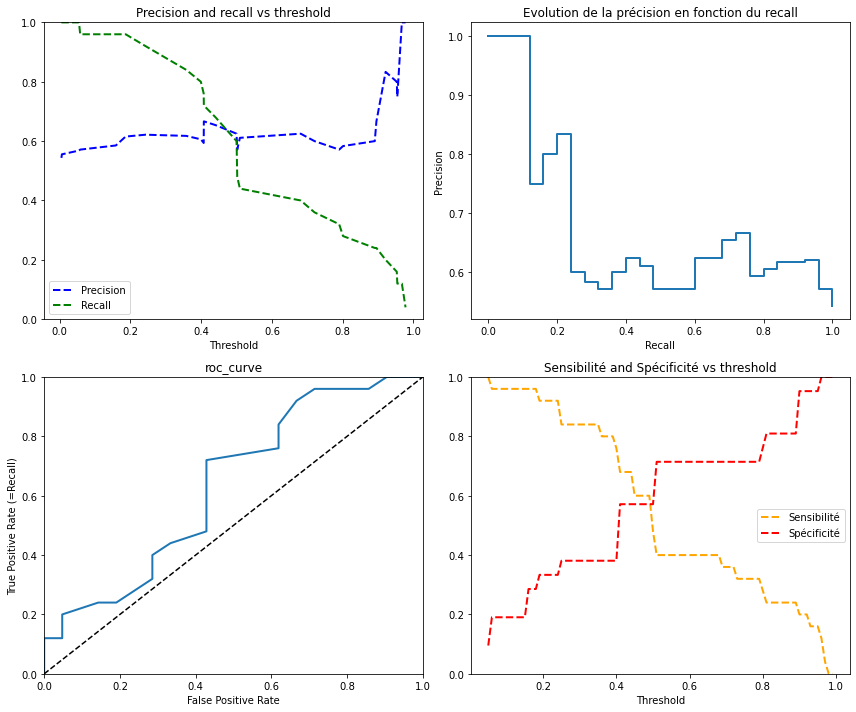

threshold = 0,5
Sensibilité :  0.48
Spécificité :  0.5714285714285714
_________________________________________________________
Best threshold : 0.81
Sensibilité : 0.24
Spécificité : 0.8095238095238095


In [47]:
tree_BL_mixte_spe = XGBClassifier(random_state=seed)
tree_BL_mixte_spe.fit(X_train.loc[:,liste_col_speci+liste_col_mixte], y_train)
pred_BL_mixte_spe = tree_BL_mixte_spe.predict(X_test.loc[:,liste_col_speci+liste_col_mixte])
model_to_plot(tree_BL_mixte_spe, X_test.loc[:,liste_col_speci+liste_col_mixte], y_test)
resultat_BL_mixte_spe = pd.DataFrame(pd.Series(scores(y_test, pred_BL_mixte_spe)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_BL_mixte_spe.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_BL_mixte_spe.loc['specificité','XGB_BL_sensi'])
dict_mixte_spe = from_model_to_bst_trhld(tree_BL_mixte_spe, X_test.loc[:,liste_col_speci+liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_spe['best_threshold'])
print('Sensibilité :', dict_mixte_spe['scores']['sensibilite'])
print('Spécificité :', dict_mixte_spe['scores']['specificité'])

### Optimisation : 

##### Sensibilité :

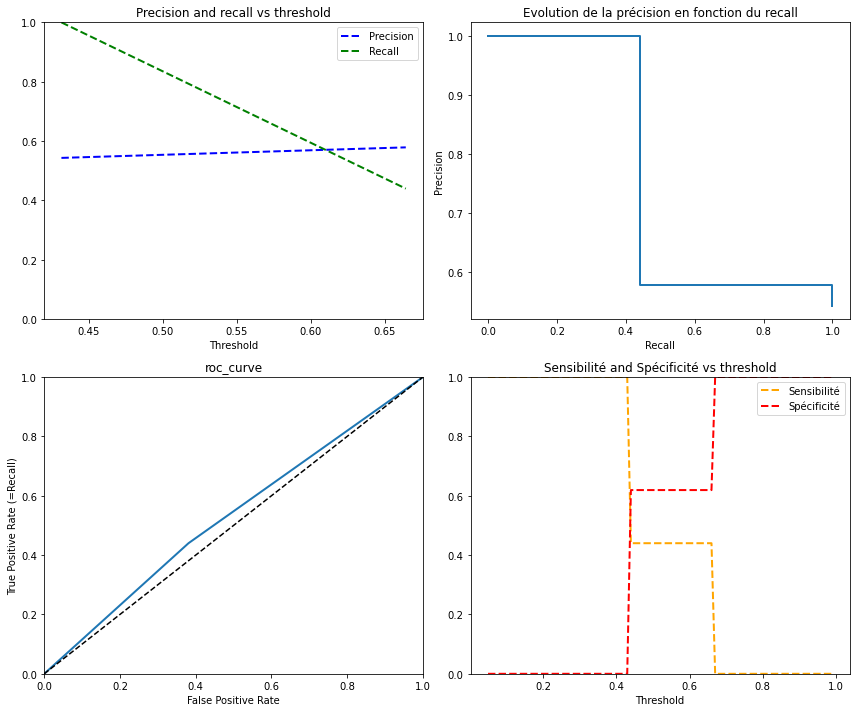

threshold = 0,5
Sensibilité :  0.44
Spécificité :  0.6190476190476191
_________________________________________________________
Best threshold : 0.67
Sensibilité : 0.0
Spécificité : 1.0


In [48]:
tree_1_opti_mixte_sensi = XGBClassifier(random_state=seed)
gs_mixte_speci_1 =  BayesSearchCV(tree_1_opti_mixte_sensi, param1, scoring=sensibilite, random_state=seed)
gs_mixte_speci_1.fit(X_train.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_train)
tree_mixte_speci_1 = XGBClassifier(**dict(gs_mixte_speci_1.best_params_),random_state=seed)
tree_mixte_speci_1.fit(X_train.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_train)
# Results :
pred_mixte_speci_1 = tree_mixte_speci_1.predict(X_test.loc[:,list(set(liste_col_speci+liste_col_mixte))])
model_to_plot(tree_mixte_speci_1, X_test.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_test)
resultat_mixte_speci_1 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_speci_1)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_speci_1.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_speci_1.loc['specificité','XGB_BL_sensi'])
dict_mixte_speci_1 = from_model_to_bst_trhld(tree_mixte_speci_1, X_test.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_speci_1['best_threshold'])
print('Sensibilité :', dict_mixte_speci_1['scores']['sensibilite'])
print('Spécificité :', dict_mixte_speci_1['scores']['specificité'])

##### Spéci :

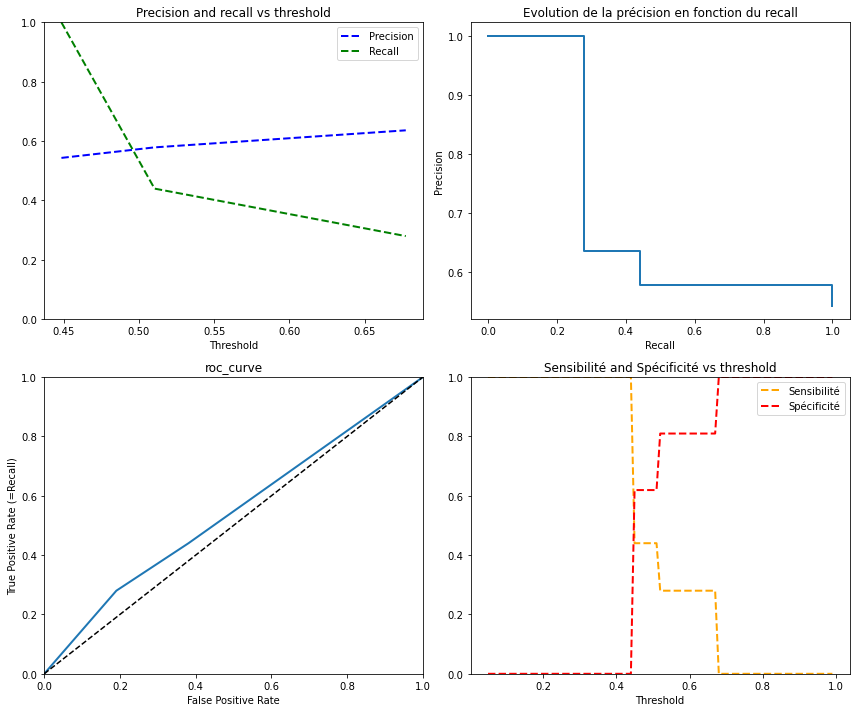

threshold = 0,5
Sensibilité :  0.44
Spécificité :  0.6190476190476191
_________________________________________________________
Best threshold : 0.52
Sensibilité : 0.28
Spécificité : 0.8095238095238095


In [49]:
tree_2_opti_mixte_ = XGBClassifier(random_state=seed)
gs_mixte_sensi2 = BayesSearchCV(tree_2_opti_mixte_, param1, scoring=specificite, random_state=seed)
gs_mixte_sensi2.fit(X_train.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_train)
tree_mixte_speci_2 = XGBClassifier(**dict(gs_mixte_sensi2.best_params_),random_state=seed)
tree_mixte_speci_2.fit(X_train.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_train)
# Results :
pred_mixte_speci_2 = tree_mixte_speci_2.predict(X_test.loc[:,list(set(liste_col_speci+liste_col_mixte))])
model_to_plot(tree_mixte_speci_2, X_test.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_test)
resultat_mixte_speci2 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_speci_2)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_speci2.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_speci2.loc['specificité','XGB_BL_sensi'])
dict_mixte_speci_2 = from_model_to_bst_trhld(tree_mixte_speci_2, X_test.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_speci_2['best_threshold'])
print('Sensibilité :', dict_mixte_speci_2['scores']['sensibilite'])
print('Spécificité :', dict_mixte_speci_2['scores']['specificité'])

##### F1 :

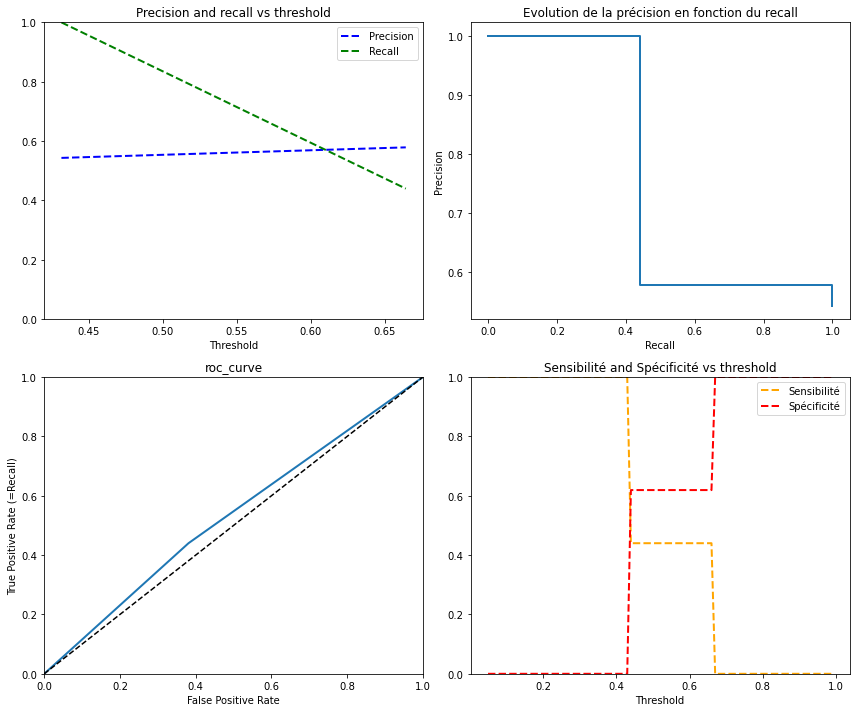

threshold = 0,5
Sensibilité :  0.44
Spécificité :  0.6190476190476191
_________________________________________________________
Best threshold : 0.67
Sensibilité : 0.0
Spécificité : 1.0


In [50]:
tree_3_opti_mixte_ = XGBClassifier(random_state=seed)
gs_mixte_sensi3 = BayesSearchCV(tree_3_opti_mixte_, param1, scoring='f1', random_state=seed)
gs_mixte_sensi3.fit(X_train.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_train)
tree_mixte_speci_3 = XGBClassifier(**dict(gs_mixte_sensi3.best_params_),random_state=seed)
tree_mixte_speci_3.fit(X_train.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_train)
# Results :
pred_mixte_speci_3 = tree_mixte_speci_3.predict(X_test.loc[:,list(set(liste_col_speci+liste_col_mixte))])
model_to_plot(tree_mixte_speci_3, X_test.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_test)
resultat_mixte_speci3 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_speci_3)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_speci3.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_speci3.loc['specificité','XGB_BL_sensi'])
dict_mixte_speci_3 = from_model_to_bst_trhld(tree_mixte_speci_3, X_test.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_speci_3['best_threshold'])
print('Sensibilité :', dict_mixte_speci_3['scores']['sensibilite'])
print('Spécificité :', dict_mixte_speci_3['scores']['specificité'])

##### Custom :

C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been

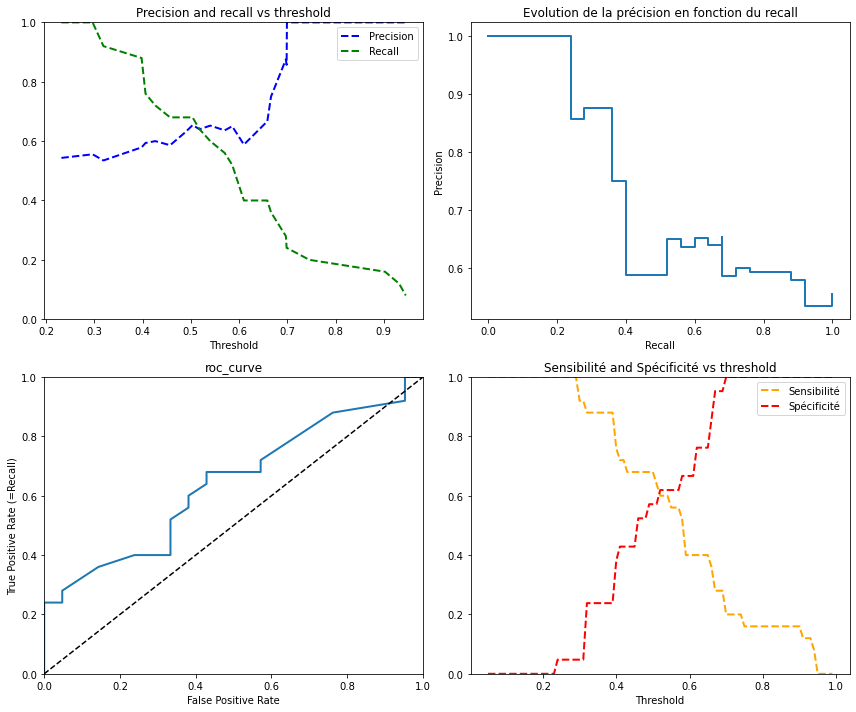

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.5714285714285714
_________________________________________________________
Best threshold : 0.66
Sensibilité : 0.36
Spécificité : 0.8571428571428571


In [51]:
tree_4_opti_mixte_ = XGBClassifier(random_state=seed)
gs_mixte_sensi4 = BayesSearchCV(tree_4_opti_mixte_, param1, scoring=scorer, random_state=seed)
gs_mixte_sensi4.fit(X_train.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_train)
tree_mixte_speci_4 = XGBClassifier(**dict(gs_mixte_sensi4.best_params_),random_state=seed)
tree_mixte_speci_4.fit(X_train.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_train)
# Results :
pred_mixte_speci_4 = tree_mixte_speci_4.predict(X_test.loc[:,list(set(liste_col_speci+liste_col_mixte))])
model_to_plot(tree_mixte_speci_4, X_test.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_test)
resultat_mixte_speci4 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_speci_4)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_speci4.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_speci4.loc['specificité','XGB_BL_sensi'])
dict_mixte_speci_4 = from_model_to_bst_trhld(tree_mixte_speci_4, X_test.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_speci_4['best_threshold'])
print('Sensibilité :', dict_mixte_speci_4['scores']['sensibilite'])
print('Spécificité :', dict_mixte_speci_4['scores']['specificité'])

##### Mix :

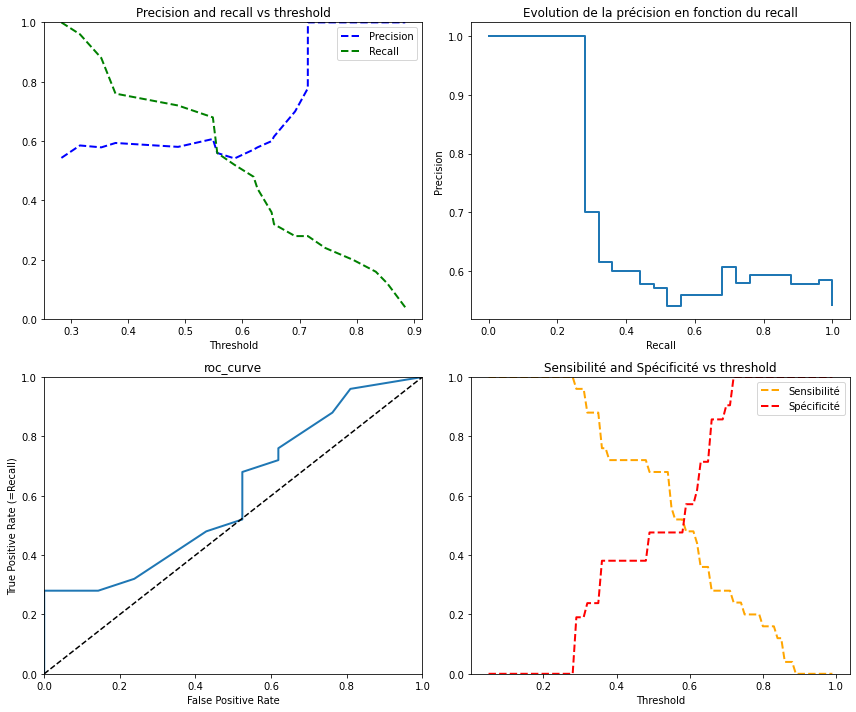

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.7
Sensibilité : 0.28
Spécificité : 0.9047619047619048


In [52]:
tree_5_opti_mixte_ = XGBClassifier(random_state=seed)
gs_mixte_sensi5 = BayesSearchCV(tree_5_opti_mixte_, param1, scoring=mix_recall, random_state=seed)
gs_mixte_sensi5.fit(X_train.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_train)
tree_mixte_speci_5 = XGBClassifier(**dict(gs_mixte_sensi5.best_params_),random_state=seed)
tree_mixte_speci_5.fit(X_train.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_train)
# Results :
pred_mixte_speci_5 = tree_mixte_speci_5.predict(X_test.loc[:,list(set(liste_col_speci+liste_col_mixte))])
model_to_plot(tree_mixte_speci_5, X_test.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_test)
resultat_mixte_speci_5 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_speci_5)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_speci_5.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_speci_5.loc['specificité','XGB_BL_sensi'])
dict_mixte_speci_5 = from_model_to_bst_trhld(tree_mixte_speci_5, X_test.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_speci_5['best_threshold'])
print('Sensibilité :', dict_mixte_speci_5['scores']['sensibilite'])
print('Spécificité :', dict_mixte_speci_5['scores']['specificité'])

##### Average precision :

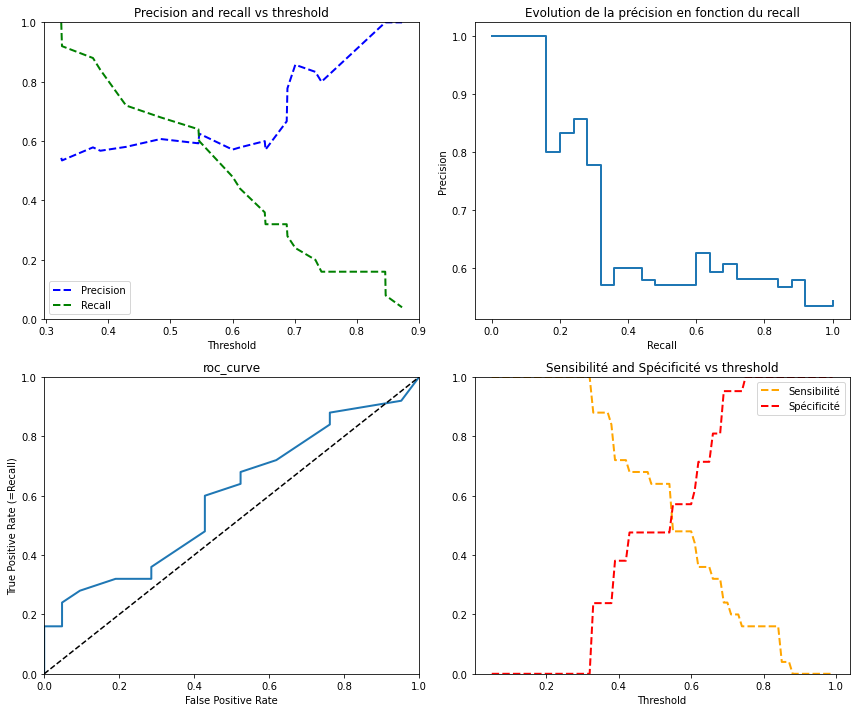

threshold = 0,5
Sensibilité :  0.64
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.66
Sensibilité : 0.32
Spécificité : 0.8095238095238095


In [53]:
tree_6_opti_mixte_ = XGBClassifier(random_state=seed)
gs_mixte_sensi6 =BayesSearchCV(tree_6_opti_mixte_, param1, scoring='average_precision', random_state=seed)
gs_mixte_sensi6.fit(X_train.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_train)
tree_mixte_speci_6 = XGBClassifier(**dict(gs_mixte_sensi6.best_params_),random_state=seed)
tree_mixte_speci_6.fit(X_train.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_train)
# Results :
pred_mixte_speci_6 = tree_mixte_speci_6.predict(X_test.loc[:,list(set(liste_col_speci+liste_col_mixte))])
model_to_plot(tree_mixte_speci_6, X_test.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_test)
resultat_mixte_speci_6 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_speci_6)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_speci_6.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_speci_6.loc['specificité','XGB_BL_sensi'])
dict_mixte_speci_6 = from_model_to_bst_trhld(tree_mixte_speci_6, X_test.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_speci_6['best_threshold'])
print('Sensibilité :', dict_mixte_speci_6['scores']['sensibilite'])
print('Spécificité :', dict_mixte_speci_6['scores']['specificité'])

# Finmix_recall

# A compléter :

## Recherche des meilleures colonnes : 

In [54]:
liste_test = ['atcd.chir.oma',
'atcd.chir.endo',
'atcd.pma',
'atcd.fiv',
'sf.dsp',
'tv.douleur.torus',
'echo.lusg',
'echo.rectum',
'irm.oma',
'irm.dig',
'irm.opac.vagin',
'avis.dig/uro',
'chir_CAP',
'dsp.type_aucun']

In [55]:
best_results_test, dict_best_set_test, y_pred_test = ML_opti_recueil(X_train, X_test, y_train, y_test, liste_test, XGBClassifier(random_state=42), 3, 18)

FP: 9 FN: 11


Exception: please check the threshold values

In [ ]:
for values in dict_best_set_test.values():
    print(values)
    model = XGBClassifier(random_state=42)
    model.fit(X_train.loc[:,values['set_col']], y_train)
    model_to_plot(model, X_test.loc[:,values['set_col']], y_test)

In [ ]:
best_results, dict_best_set, y_pred = ML_opti_recueil(X_train, X_test, y_train, y_test, liste_col_speci, XGBClassifier(random_state=42), 3, 18)

# Feature selection : 

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector